In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
%matplotlib inline
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential, load_model, clone_model
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12687409599978408836
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2252026676
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4759029960590652423
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

# 6. Natural Language Processing

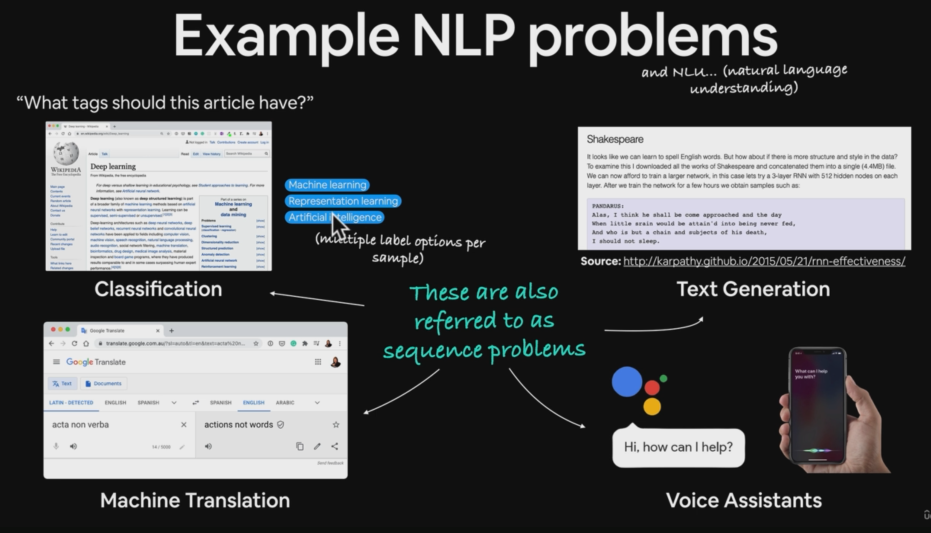

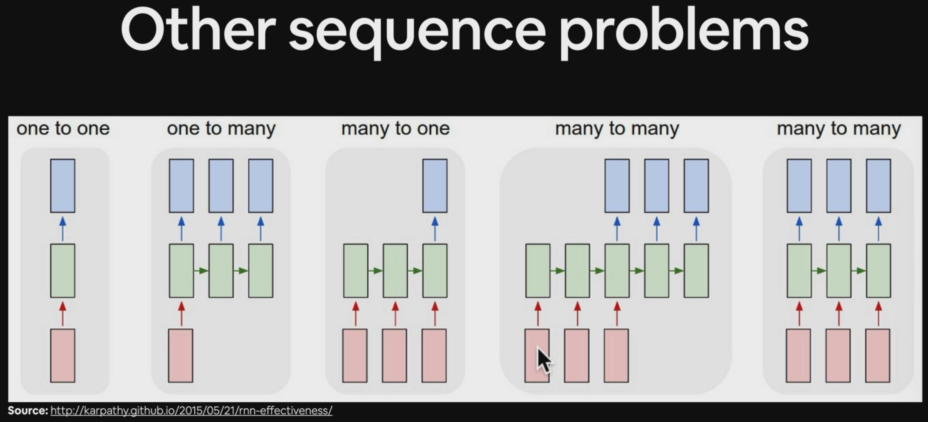

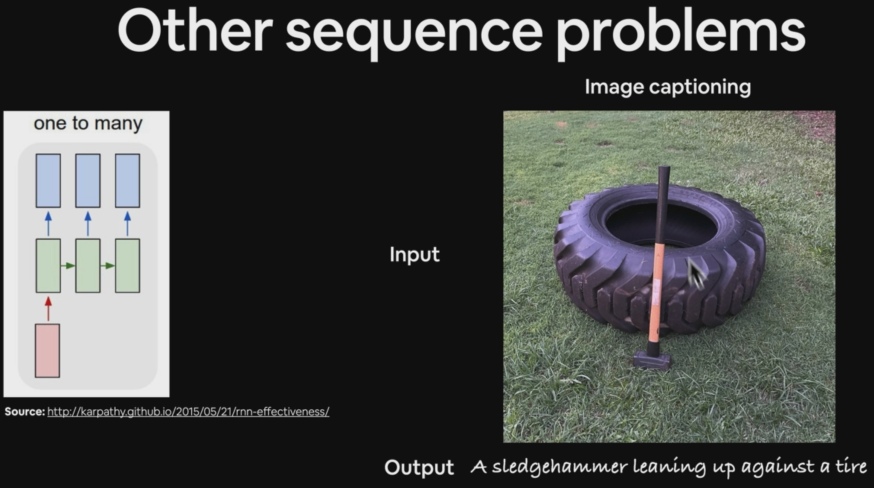

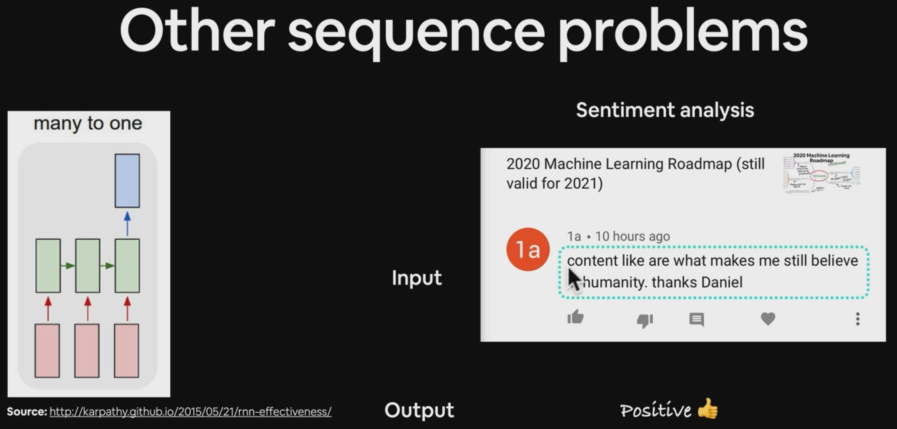

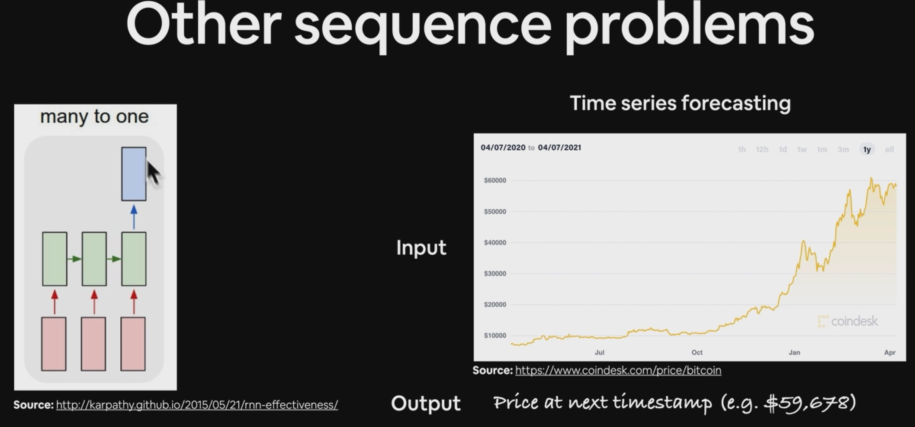

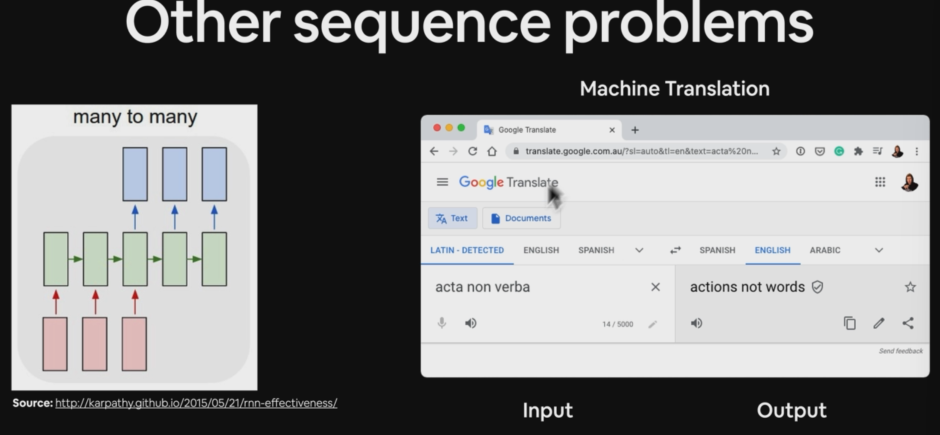

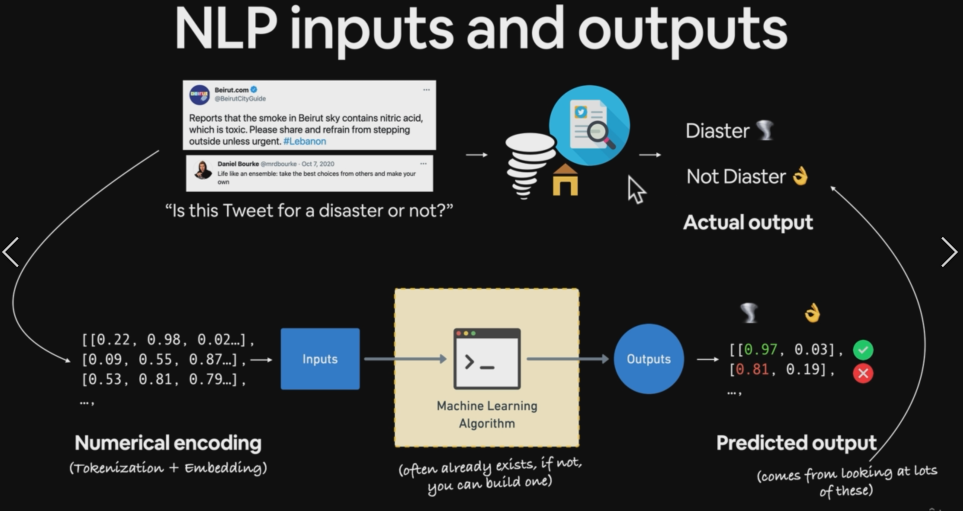

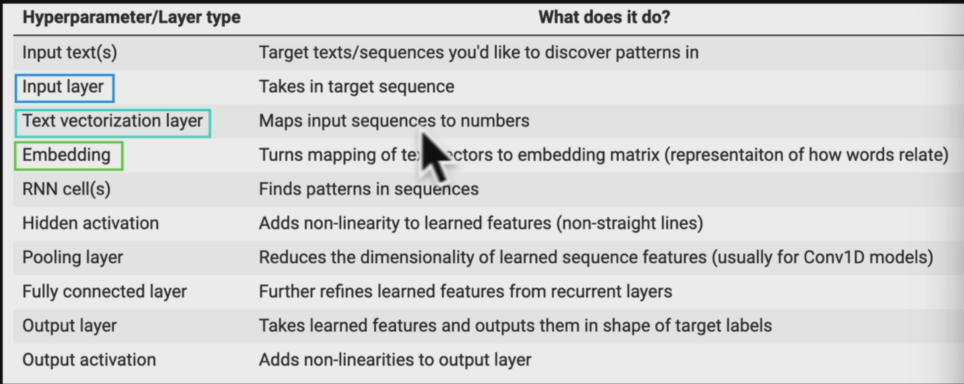

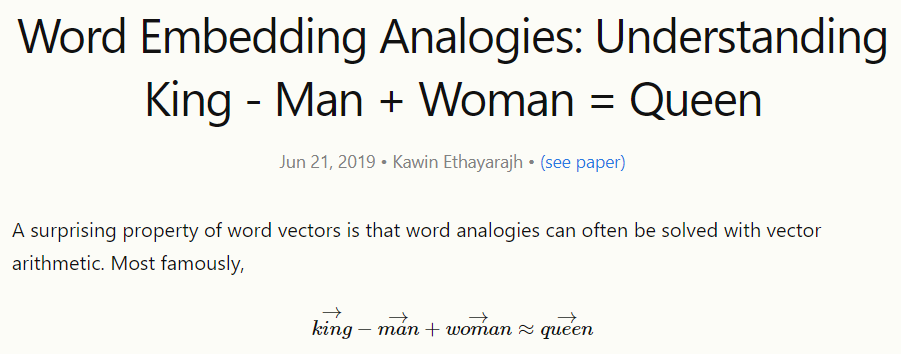

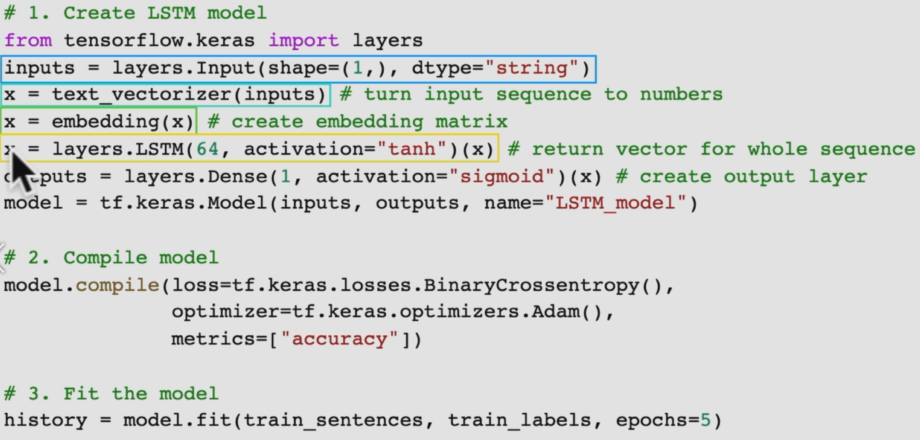

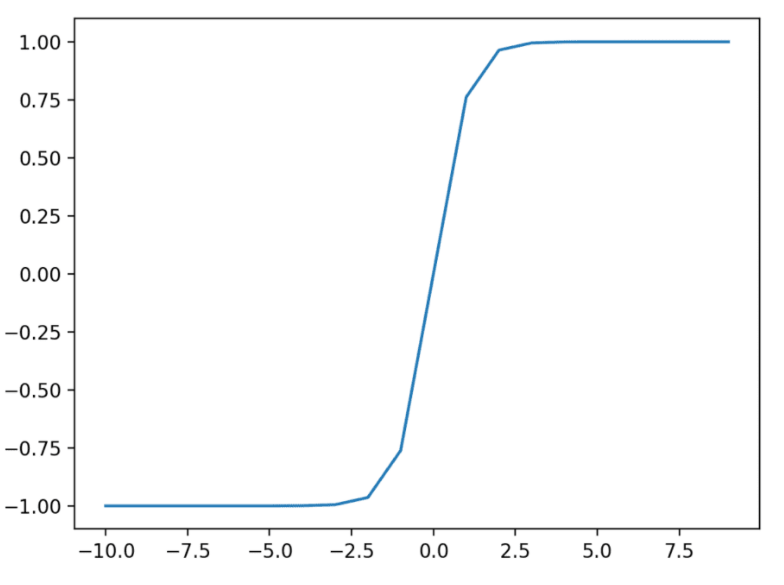

>The Tanh activation function is calculated as follows:
>
>**(e^x – e^-x) / (e^x + e^-x)**

## 6.1 Becoming one into data, visualizing the data

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 Ti (UUID: GPU-e78c5d0c-75a4-0a7a-836d-3913f48a83a7)


In [3]:
import helper_functions as helper

In [4]:
train_df = pd.read_csv('nlp_getting_started/train.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train_df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [7]:
train_df.isnull().sum(axis=0)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train_df.loc[100]

id                                                        144
keyword                                              accident
location                                                   UK
text        .@NorwayMFA #Bahrain police had previously die...
target                                                      1
Name: 100, dtype: object

In [9]:
train_df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [10]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [11]:
# Shuffle train data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

id      keyword               location  \
2644  3796  destruction                    NaN   
2227  3185       deluge                    NaN   
5448  7769       police                     UK   
132    191   aftershock                    NaN   
6845  9810       trauma  Montgomery County, MD   

                                                   text  target  
2644  So you have a new weapon that can cause un-ima...       1  
2227  The f$&amp;@ing things I do for #GISHWHES Just...       0  
5448  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1  
132   Aftershock back to school kick off was great. ...       0  
6845  in response to trauma Children of Addicts deve...       0

In [12]:
test_df = pd.read_csv('nlp_getting_started/test.csv')
test_df.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [13]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [14]:
len(train_df), len(test_df)

(7613, 3263)

In [15]:
random_index = np.random.choice(len(train_df), size=10)
random_index

text_total = []
target_total = []
for i in random_index:
    text = train_df_shuffled['text'][i]
    text_total.append(text)
    target = train_df_shuffled['target'][i]
    target_total.append(target)

target_str = []
for i in target_total:
    if i == 1:
        target = 'disaster'
    else:
        target = 'not disaster'
    target_str.append(target)

for i in range(len(text_total)):
    print(f'Target: {target_str[i]}')
    print(f'Text:\n {text_total[i]}\n')
    print('-----------\n')

Target: disaster
Text:
 Condemnation clearly replacing the latest response aimlessly dryer evacuate detersion de: HLg

-----------

Target: not disaster
Text:
 Why are you engulfed by low self-image? Take the quiz: http://t.co/CImUbwEyiB http://t.co/9R5FstS7Bd

-----------

Target: disaster
Text:
 JAX issues Hazardous Weather Outlook (HWO)  http://t.co/u9fCb8dz3h #WX

-----------

Target: disaster
Text:
 (#LosDelSonido) Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Ma...  (#IvanBerroa)

-----------

Target: disaster
Text:
 NASAHurricane? EASTERN PACIFIC *Full Update* Satellite Sees Formation of Eastern Pacific's Tropical Storm Hilda
ThÛ_ http://t.co/KsXTo8NKNl

-----------

Target: not disaster
Text:
 I really wants a rolo blizzard but mom said no so I guess no DQ tonight

-----------

Target: not disaster
Text:
 WWE 2K15: Universe Mode - Part 149 - OBLITERATE!!: http://t.co/0oms8rI3l1 via @YouTube

-----------

Target: not disast

In [16]:
train_df

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

In [17]:
# Split train and test data
train_sentences, test_sentences, train_labels, test_labels= train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                             train_df_shuffled['target'].to_numpy(),
                                                                             test_size=0.1,
                                                                             random_state=42)

In [18]:
len(train_sentences), len(test_sentences)

(6851, 762)

In [19]:
train_sentences[:5], train_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array([0, 0, 1, 0, 0], dtype=int64))

## 6.2 Tokenization vs Embedding

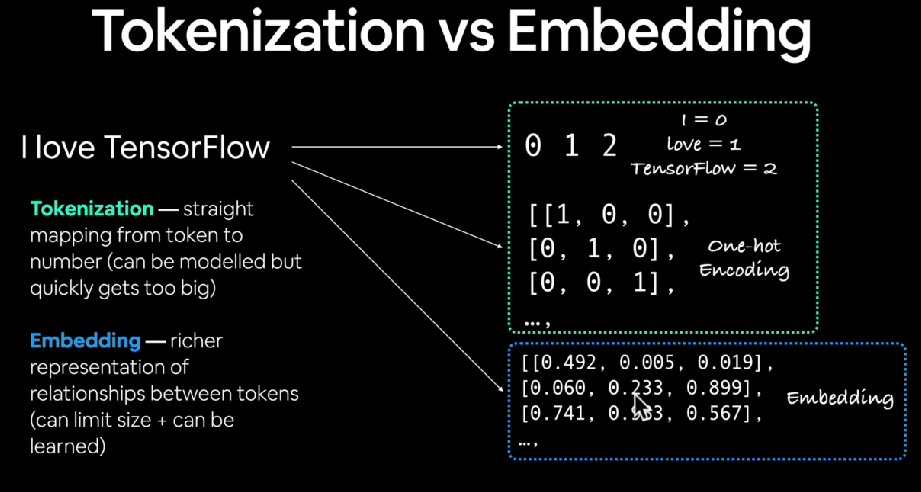

### Text Vectorization (tokenization)

>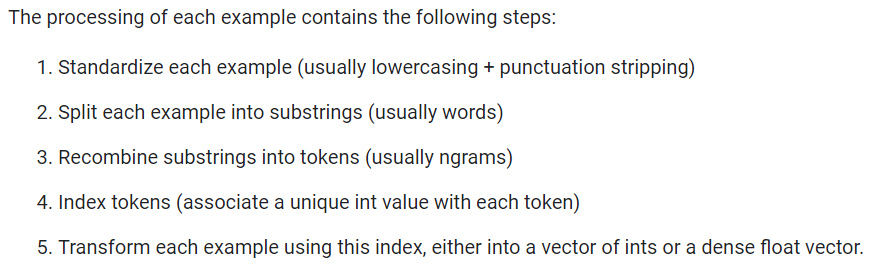

In [91]:
# Text vectorization (tokenization)
text_vectorizer = layers.TextVectorization(max_tokens=10000, # how many word in vocabulary (automatically add <OOV>
                                           standardize='lower_and_strip_punctuation',
                                           split='whitespace',
                                           ngrams=None, # create groups of n-words,
                                           output_mode='int',
                                           output_sequence_length=15, # how long do you want your sequence to be
                                           pad_to_max_tokens=True)

In [83]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [89]:
# Find the average number of tokens (words) in the training tweets
np.average([len(i.split()) for i in train_sentences])

14.901036345059115

In [93]:
text_vectorizer = layers.TextVectorization(max_tokens=10000,
                                           output_sequence_length=15)

In [95]:
# Fit the text vectorization to training text
text_vectorizer.adapt(train_sentences)

In [102]:
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [96]:
# Create a sample and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer(sample_sentence)

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)>

In [106]:
text_vectorizer.vocabulary_size()

10000

In [117]:
random_sentence = np.random.choice(train_sentences)
print(f"Original text: {random_sentence}\n\nVectorized: {text_vectorizer(random_sentence)}")

Original text: I already had my phone updated to 8.4 and somehow my phone crashed and I had to restore it and they're not letting me restore it

Vectorized: [   8  659   94   13  390 1932    5 6301    7 2289   13  390  402    7
    8]


In [121]:
# Get unique words from vocabulary
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'a', 'in']

In [122]:
text_vectorizer.get_vocabulary()[-5:]

['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']

In [124]:
text_vectorizer.vocabulary_size()

10000

### Embeddings
Parameters that most important:
* `input_dim` = the size of our vocabulary
* `output_dim`
* `input_length` = length of the sequences being passed 

In [128]:
embedding = layers.Embedding(input_dim=10000,
                             output_dim=128, # better divisible by 8
                             input_length=15)

In [132]:
random_sentence = np.random.choice(train_sentences)
print(f"Original text: {random_sentence}\n\nEmbedded: {embedding(text_vectorizer(random_sentence))}\n\n {embedding(text_vectorizer(random_sentence)).shape}")

Original text: I sent my emails why are the TRINNA hold me hostage  rapping me up ??

Embedded: [[ 0.02579576 -0.02432218 -0.00814551 ...  0.02262222  0.01982405
   0.03682348]
 [ 0.01406587 -0.049196    0.04142514 ...  0.02307541 -0.00610684
   0.01568544]
 [-0.04655151 -0.00923691 -0.04901251 ... -0.00963476  0.01149026
   0.04965946]
 ...
 [-0.04009421 -0.01447604 -0.01206229 ... -0.02413419 -0.04006936
   0.03161195]
 [ 0.03633766  0.03325597 -0.01883047 ... -0.0073357   0.00579464
  -0.01442742]
 [ 0.00615975  0.03720662  0.00066246 ... -0.04464114 -0.0194237
  -0.03469787]]

 (15, 128)


In [133]:
random_sentence

'I sent my emails why are the TRINNA hold me hostage  rapping me up ??'

In [134]:
embed = embedding(text_vectorizer(random_sentence))
embed[0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02579576, -0.02432218, -0.00814551, -0.04614222, -0.02857575,
        0.00079012,  0.02101726, -0.02733952, -0.02973452,  0.02380056,
        0.01346366, -0.01390959,  0.04398302,  0.01209017, -0.0036258 ,
        0.0154337 , -0.03692148, -0.04057244, -0.0379127 ,  0.01332353,
       -0.01022937, -0.0197723 ,  0.01409907,  0.02088878, -0.00854645,
        0.0396609 ,  0.02691643,  0.00370023,  0.00684909, -0.01457398,
        0.04825694, -0.04799309, -0.01842811, -0.01205022, -0.03246441,
       -0.01635016, -0.00612766, -0.02641901, -0.01867812, -0.01873768,
       -0.00445666,  0.03979839, -0.03694662,  0.01208308, -0.01887944,
       -0.00270867, -0.04122724, -0.03534825,  0.00258428,  0.01711155,
       -0.0206727 , -0.02688642,  0.01278314, -0.04013335, -0.02678558,
        0.01134346, -0.03938813,  0.00286277,  0.03472875, -0.00438233,
        0.021029  ,  0.02621419,  0.03353721,  0.0291054 , -0.01244011,
       -0.030341

## 6.3 Modelling

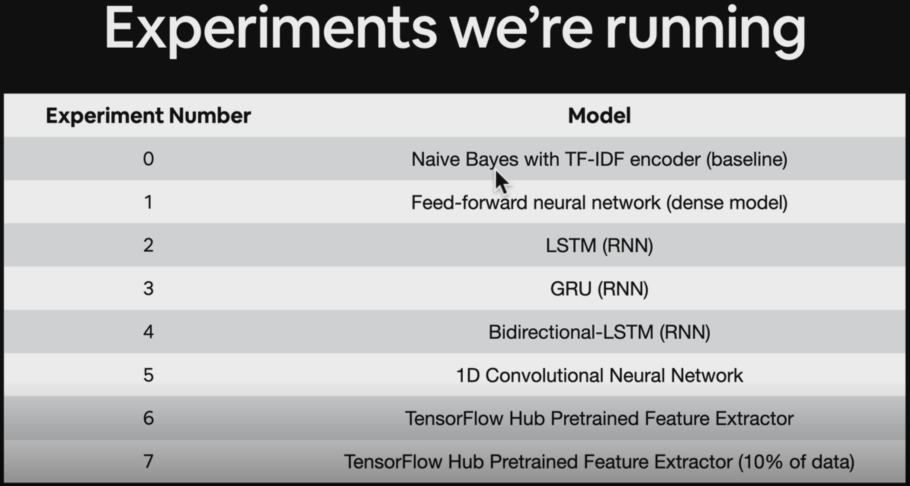

### Creating a baseline

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer # turn text into number
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline

In [138]:
# Create a pipeline
baseline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('clf', MultinomialNB()) # model the text
])

# Fit the pipeline
baseline.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [140]:
# Evaluate our baseline model
baseline.score(test_sentences, test_labels)

0.7926509186351706

In [141]:
baseline_pred = baseline.predict(test_sentences)

In [152]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report

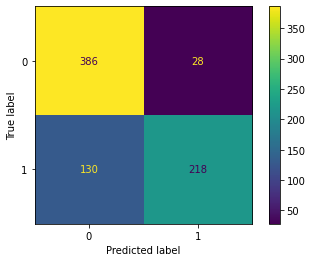

In [150]:
ConfusionMatrixDisplay.from_predictions(test_labels, baseline_pred);

In [151]:
print(classification_report(test_labels, baseline_pred))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       414
           1       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762



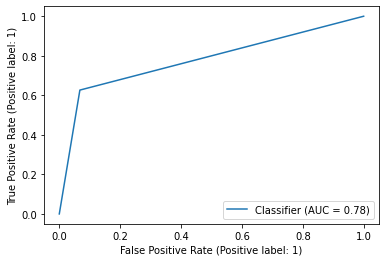

In [155]:
RocCurveDisplay.from_predictions(test_labels, baseline_pred);

### Model 1: simple dense model

In [199]:
# Set a random seed
tf.random.set_seed(42)

# Set the inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer') # one sequence each time

# Set the Text Vectorization layer
tokenization = layers.TextVectorization(max_tokens=10000,
                                       output_sequence_length=15, 
                                       name='tokenization_layer')
tokenization.adapt(train_sentences)

# Set the Embedding layer
embedding = layers.Embedding(input_dim=10000,
                            output_dim=128,
                            input_length=15)

# Passing the input data into tokenization layer 
x = tokenization(inputs)

# Passing the tokenized data into embedding layer
x = embedding(x)

# Set the feature extraction layer
x = layers.GlobalAveragePooling1D()(x)

# Set the ouputs
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the inputs and outputs into Model
model_1 = tf.keras.Model(inputs, outputs)

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('NLP/model_1')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='NLP/model_1/model_1.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Compile the model
model_1.compile(optimizer=Adam(),
               loss=BinaryCrossentropy(),
               metrics='accuracy')

# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[tensorboard, checkpoint])

Epoch 1/10
209/215 [============================>.] - ETA: 0s - loss: 0.6109 - accuracy: 0.6905
Epoch 00001: val_accuracy improved from -inf to 0.75722, saving model to NLP/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: NLP/model_1\model_1.ckpt\assets
215/215 [==============================] - 3s 11ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/10
207/215 [===========================>..] - ETA: 0s - loss: 0.4427 - accuracy: 0.8178
Epoch 00002: val_accuracy improved from 0.75722 to 0.78478, saving model to NLP/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: NLP/model_1\model_1.ckpt\assets
215/215 [==============================] - 2s 9ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/10
211/215 [============================>.] - ETA: 0s - loss: 0.3468 - accuracy: 0.8605
Epoch 00003: val_accuracy improved from 0.78478 to 0.79003, saving model to NLP/model_1\model_1.ckpt
INFO:tensorflow

In [195]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 tokenization_layer (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [196]:
model_1.evaluate(test_sentences, test_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.6181 - accuracy: 0.7795


[0.6180838942527771, 0.7795275449752808]

In [48]:
model_1_best = load_model('NLP/model_1/model_1.ckpt/')

In [49]:
model_1_best.evaluate(test_sentences, test_labels)

24/24 [==============================] - 0s 5ms/step - loss: 0.4750 - accuracy: 0.7979


[0.4749770164489746, 0.7979002594947815]

In [50]:
model_1_pred = np.round(model_1_best.predict(test_sentences))

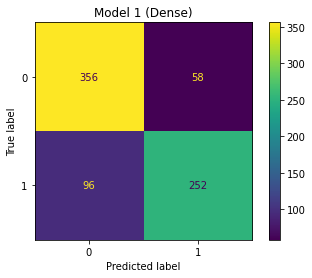

In [211]:
ConfusionMatrixDisplay.from_predictions(test_labels, model_1_pred)
plt.title('Model 1 (Dense)');

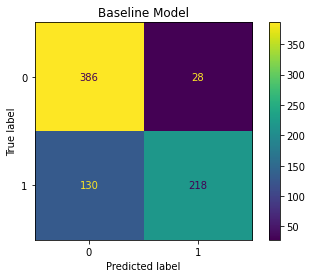

In [210]:
ConfusionMatrixDisplay.from_predictions(test_labels, baseline_pred)
plt.title('Baseline Model');

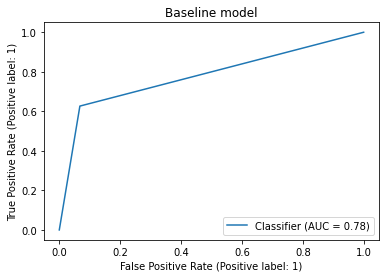

In [213]:
RocCurveDisplay.from_predictions(test_labels, baseline_pred)
plt.title('Baseline model');

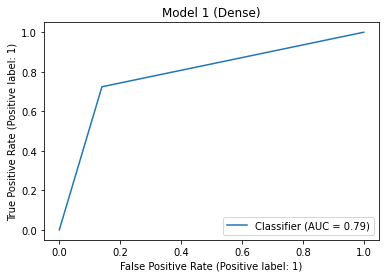

In [215]:
RocCurveDisplay.from_predictions(test_labels, model_1_pred)
plt.title('Model 1 (Dense)');

In [218]:
print(classification_report(test_labels, baseline_pred))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       414
           1       0.89      0.63      0.73       348

    accuracy                           0.79       762
   macro avg       0.82      0.78      0.78       762
weighted avg       0.81      0.79      0.79       762



In [217]:
print(classification_report(test_labels, model_1_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       414
           1       0.81      0.72      0.77       348

    accuracy                           0.80       762
   macro avg       0.80      0.79      0.79       762
weighted avg       0.80      0.80      0.80       762



In [220]:
tokenization.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [221]:
len(tokenization.get_vocabulary())

10000

In [222]:
model_1_best.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 tokenization_layer (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_7 (Embedding)     (None, None, 128)         1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 output_layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [233]:
embed_weights = model_1_best.get_layer('embedding_7').get_weights()[0]

In [234]:
embed_weights.shape, embed_weights

((10000, 128),
 array([[ 0.00170407,  0.01410384, -0.03338241, ..., -0.04312973,
         -0.00951249,  0.01787746],
        [ 0.03840138, -0.03643676, -0.04098626, ...,  0.00154099,
          0.02882065,  0.03218934],
        [ 0.00287731,  0.05760805, -0.00606029, ..., -0.07487909,
         -0.05112416,  0.0181783 ],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00872555,  0.05753858, -0.01838919, ..., -0.06002949,
         -0.0088384 ,  0.03366812],
        [-0.02312179,  0.04848679, -0.06138655, ..., -0.00923426,
         -0.0734271 ,  0.00410819]], dtype=float32))

In [235]:
vocab = tokenization.get_vocabulary()

In [236]:
# Create embedding files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = embed_weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
    
out_v.close()
out_m.close()

## 6.4 RNN
>Use the representation of previous inpts to aid the representation of a later input

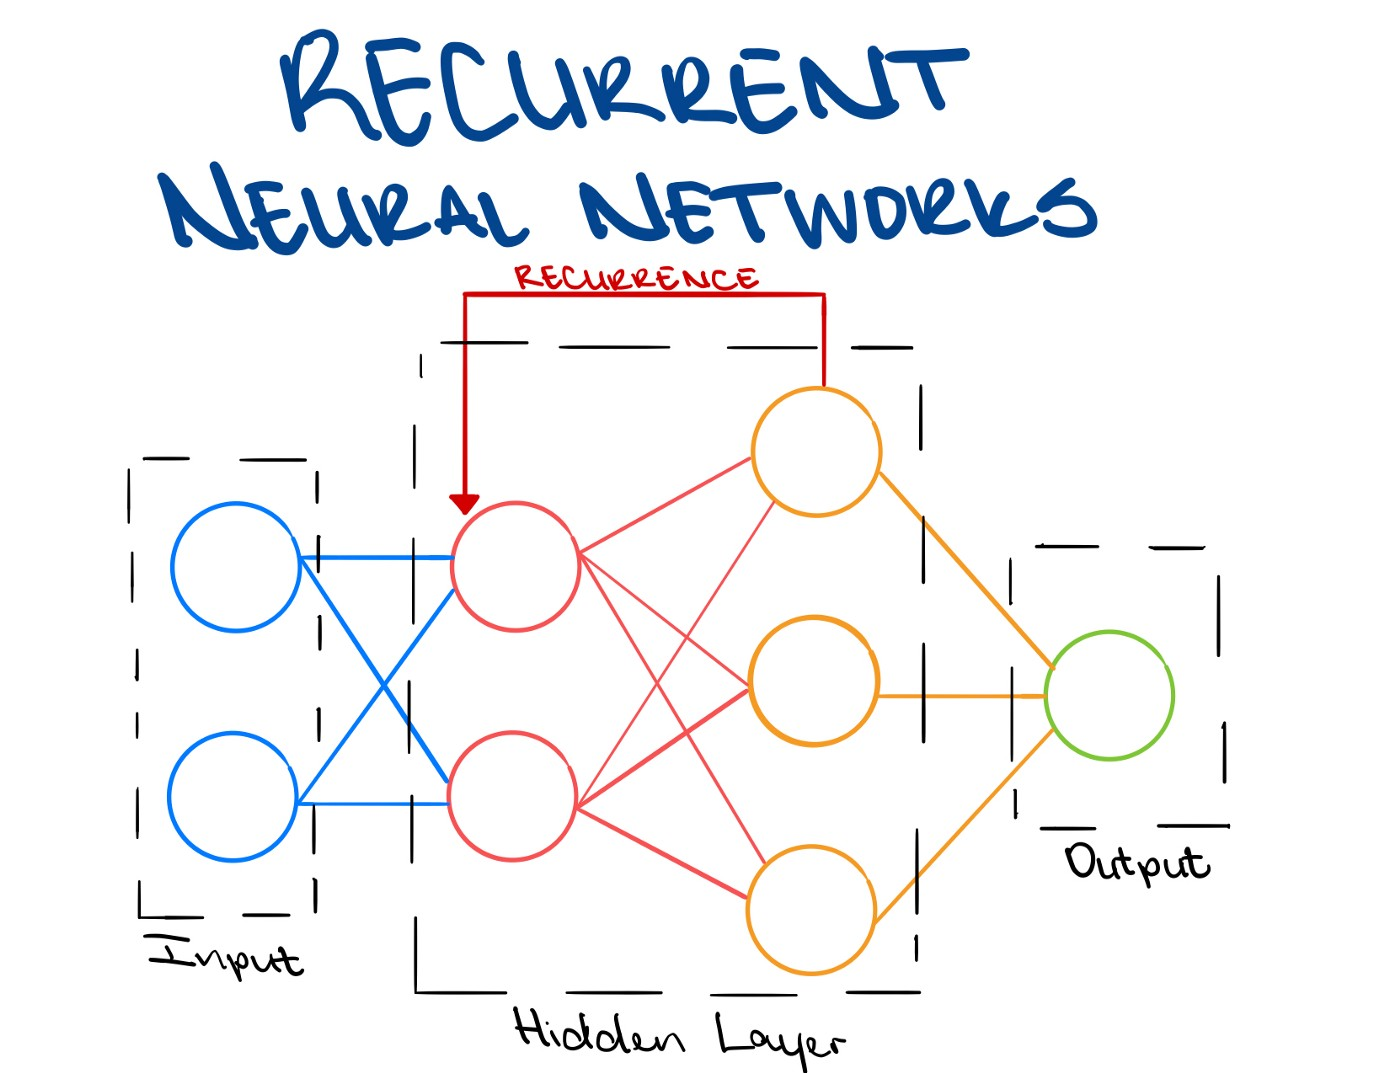

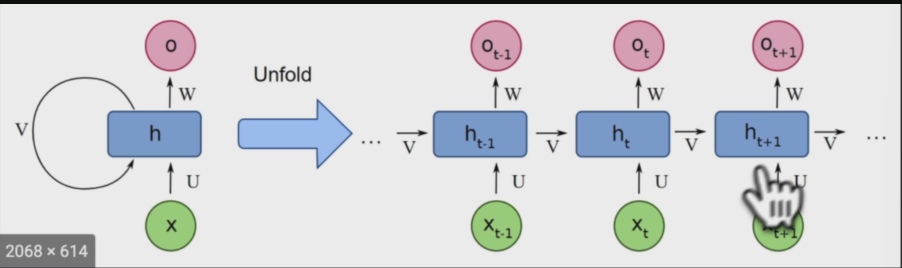

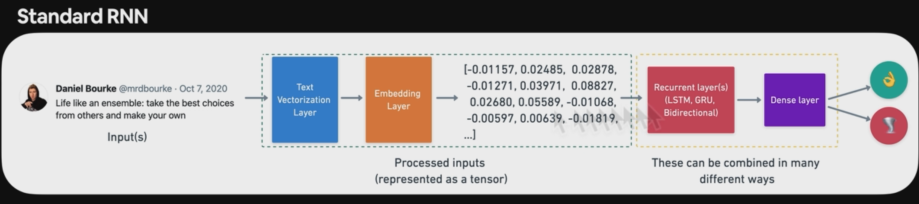

### LSTM (Long Short Term Memory)

In [20]:
# Set random seed 
tf.random.set_seed(42)

# Set the inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Set the Text Vectorization (Tokenization) layer
tokenization = layers.TextVectorization(max_tokens=10000,
                                        output_sequence_length=15,
                                        name='tokenization_layer')

# Fit (adapt) the tokenization layer
tokenization.adapt(train_sentences)

# Pass the input text into tokenization layer (convert texts into numbers)
x = tokenization(inputs)

# Pass the tokenized text as number representation into Embedding layer
embedding = layers.Embedding(input_dim=10000,
                             output_dim=128,
                             input_length=15)
x = embedding(x)

# Set LSTM layer
x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
x = layers.LSTM(units=64)(x)

# Set Dense layer
x = layers.Dense(units=64, activation='relu')(x)

# Set the outputs 
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the inputs and outputs to Model
model_2 = tf.keras.Model(inputs, outputs)

# Set the callbacks
tensorboard = tf.keras.callbacks.TensorBoard('NLP/model_2')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='NLP/model_2/model_2.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Compile the model
model_2.compile(optimizer=Adam(),
                loss=BinaryCrossentropy(),
                metrics='accuracy')

# Fit the model
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[tensorboard, checkpoint])

Epoch 1/10
215/215 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.7475
Epoch 00001: val_accuracy improved from -inf to 0.78084, saving model to NLP/model_2\model_2.ckpt


INFO:tensorflow:Assets written to: NLP/model_2\model_2.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_2\model_2.ckpt\assets


215/215 [==============================] - 22s 60ms/step - loss: 0.5105 - accuracy: 0.7475 - val_loss: 0.4579 - val_accuracy: 0.7808
Epoch 2/10
212/215 [============================>.] - ETA: 0s - loss: 0.3211 - accuracy: 0.8703
Epoch 00002: val_accuracy did not improve from 0.78084
215/215 [==============================] - 3s 14ms/step - loss: 0.3205 - accuracy: 0.8704 - val_loss: 0.4995 - val_accuracy: 0.7769
Epoch 3/10
210/215 [============================>.] - ETA: 0s - loss: 0.2236 - accuracy: 0.9146
Epoch 00003: val_accuracy did not improve from 0.78084
215/215 [==============================] - 3s 14ms/step - loss: 0.2233 - accuracy: 0.9143 - val_loss: 0.5521 - val_accuracy: 0.7559
Epoch 4/10
211/215 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9433 ETA: 0s - loss: 0.1621 - accuracy: 
Epoch 00004: val_accuracy did not improve from 0.78084
215/215 [==============================] - 3s 14ms/step - loss: 0.1623 - accuracy: 0.9435 - val_loss: 0.6422 - val

In [21]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 tokenization_layer (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                             

In [47]:
model_2_best = load_model('NLP/model_2/model_2.ckpt/')

In [25]:
model_2_best.evaluate(test_sentences, test_labels)

24/24 [==============================] - 1s 34ms/step - loss: 0.4731 - accuracy: 0.7808


[0.47311830520629883, 0.7808399200439453]

In [31]:
model_2_pred = np.round(model_2_best.predict(test_sentences))

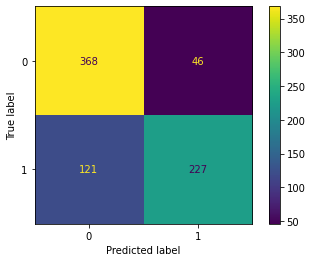

In [32]:
ConfusionMatrixDisplay.from_predictions(test_labels, model_2_pred);

In [33]:
print(classification_report(test_labels, model_2_pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.82       414
           1       0.83      0.65      0.73       348

    accuracy                           0.78       762
   macro avg       0.79      0.77      0.77       762
weighted avg       0.79      0.78      0.78       762



### GRU (Gated Recurrent Unit)
>The GRU cell has similar features to a LSTM cells but with less parameter

In [55]:
# Set random seed
tf.random.set_seed(42)

# Create inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Passing the input text to tokenization layer to convert from string into number
tokenization = layers.TextVectorization(max_tokens=10000,
                                       output_sequence_length=15)

# Fit the tokenization layer (adapt)
tokenization.adapt(train_sentences)

# Pass the inputs into tokenization layer
x = tokenization(inputs)

# Pass the tokenized text (number) into embedding layer
embedding = layers.Embedding(input_dim=10000,
                            output_dim=128,
                            input_length=15)
x = embedding(x)

# Pass into GRU layer
x = layers.GRU(units=64, return_sequences=True)(x)# stacking GRU layer with embedding, prevent error
x = layers.GRU(units=64)(x)

# Create Dense layer
x = layers.Dense(units=64, activation='relu')(x)

# Create outputs
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the inputs and outputs into Model
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(optimizer=Adam(),
               loss=BinaryCrossentropy(),
               metrics='accuracy')

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('NLP/model_3')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='NLP/model_3/model_3.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Fit the model
history_model_3 = model_3.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[tensorboard, checkpoint])

Epoch 1/10
212/215 [============================>.] - ETA: 0s - loss: 0.5243 - accuracy: 0.7344
Epoch 00001: val_accuracy improved from -inf to 0.78871, saving model to NLP/model_3\model_3.ckpt


INFO:tensorflow:Assets written to: NLP/model_3\model_3.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_3\model_3.ckpt\assets


215/215 [==============================] - 11s 37ms/step - loss: 0.5240 - accuracy: 0.7348 - val_loss: 0.4501 - val_accuracy: 0.7887
Epoch 2/10
215/215 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8663
Epoch 00002: val_accuracy did not improve from 0.78871
215/215 [==============================] - 2s 10ms/step - loss: 0.3249 - accuracy: 0.8663 - val_loss: 0.4903 - val_accuracy: 0.7822
Epoch 3/10
213/215 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9153
Epoch 00003: val_accuracy did not improve from 0.78871
215/215 [==============================] - 2s 10ms/step - loss: 0.2243 - accuracy: 0.9153 - val_loss: 0.5382 - val_accuracy: 0.7638
Epoch 4/10
215/215 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9432
Epoch 00004: val_accuracy did not improve from 0.78871
215/215 [==============================] - 2s 10ms/step - loss: 0.1630 - accuracy: 0.9432 - val_loss: 0.6386 - val_accuracy: 0.7769
Epoch 5/10
215/215

In [56]:
model_3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_7 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_13 (GRU)                (None, 15, 64)            37248     
                                                                 
 gru_14 (GRU)                (None, 64)                24960     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                           

In [57]:
model_3_best = load_model('NLP/model_3/model_3.ckpt/')

In [58]:
model_3_best.evaluate(test_sentences, test_labels)

24/24 [==============================] - 1s 28ms/step - loss: 0.4595 - accuracy: 0.7913


[0.45950576663017273, 0.7913385629653931]

In [59]:
model_3_pred = np.round(model_3_best.predict(test_sentences))

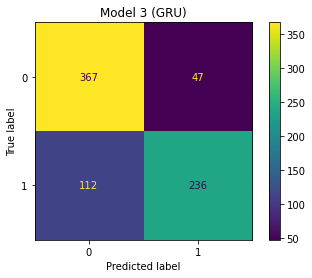

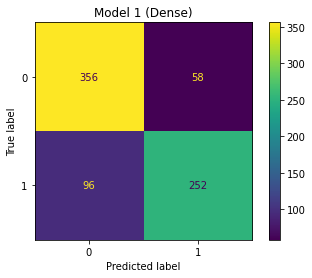

In [60]:
ConfusionMatrixDisplay.from_predictions(test_labels, model_3_pred);
plt.title('Model 3 (GRU)')
ConfusionMatrixDisplay.from_predictions(test_labels, model_1_pred)
plt.title('Model 1 (Dense)');

### LSTM Bidirectional

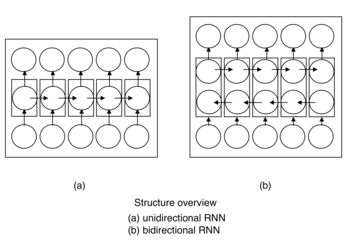

>Normal RNN's go from left to right (just like you'd read an English sentence) however Bidirectional RNN goes from right to left as well as left to right.

In [67]:
# Set random seed
tf.random.set_seed(42)

# Create the inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Passing the input text to tokenization layer to convert from string into number
tokenization = layers.TextVectorization(max_tokens=10000,
                                       output_sequence_length=15)

# Fit the tokenization layer (adapt)
tokenization.adapt(train_sentences)

# Pass the inputs into tokenization layer
x = tokenization(inputs)

# Pass the tokenized text (number) into embedding layer
embedding = layers.Embedding(input_dim=10000,
                            output_dim=128,
                            input_length=15)
x = embedding(x)

# Create Bidirectional layer
x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=64))(x)

# Create the outputs
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the input into Model
model_4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_4.compile(optimizer=Adam(),
               loss=BinaryCrossentropy(),
               metrics='accuracy')

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('NLP/model_4')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='NLP/model_4/model_4.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Fit the model
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[tensorboard, checkpoint])

Epoch 1/10
214/215 [============================>.] - ETA: 0s - loss: 0.5054 - accuracy: 0.7503
Epoch 00001: val_accuracy improved from -inf to 0.78871, saving model to NLP/model_4\model_4.ckpt


INFO:tensorflow:Assets written to: NLP/model_4\model_4.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_4\model_4.ckpt\assets


215/215 [==============================] - 27s 104ms/step - loss: 0.5057 - accuracy: 0.7501 - val_loss: 0.4546 - val_accuracy: 0.7887
Epoch 2/10
214/215 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8768
Epoch 00002: val_accuracy did not improve from 0.78871
215/215 [==============================] - 3s 16ms/step - loss: 0.3115 - accuracy: 0.8768 - val_loss: 0.5145 - val_accuracy: 0.7690
Epoch 3/10
214/215 [============================>.] - ETA: 0s - loss: 0.2099 - accuracy: 0.9187
Epoch 00003: val_accuracy did not improve from 0.78871
215/215 [==============================] - 3s 15ms/step - loss: 0.2098 - accuracy: 0.9187 - val_loss: 0.5697 - val_accuracy: 0.7559
Epoch 4/10
212/215 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9511
Epoch 00004: val_accuracy did not improve from 0.78871
215/215 [==============================] - 3s 16ms/step - loss: 0.1417 - accuracy: 0.9512 - val_loss: 0.6899 - val_accuracy: 0.7677
Epoch 5/10
215/21

In [68]:
model_4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_12 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding_13 (Embedding)    (None, 15, 128)           1280000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 15, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                          

In [69]:
model_4_best = load_model('NLP/model_4/model_4.ckpt/')

In [71]:
model_4_best.evaluate(test_sentences, test_labels)

24/24 [==============================] - 2s 49ms/step - loss: 0.4625 - accuracy: 0.7887


[0.4624834954738617, 0.7887139320373535]

In [74]:
model_4_pred = np.round(model_4.predict(test_sentences))

In [75]:
print(classification_report(test_labels, model_4_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       414
           1       0.72      0.67      0.70       348

    accuracy                           0.73       762
   macro avg       0.73      0.73      0.73       762
weighted avg       0.73      0.73      0.73       762



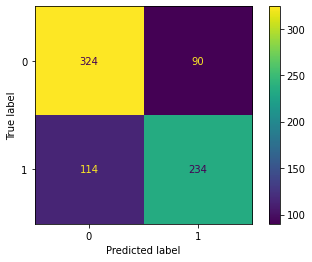

In [77]:
ConfusionMatrixDisplay.from_predictions(test_labels, model_4_pred);

### 1D Convolutional Neural Netwok

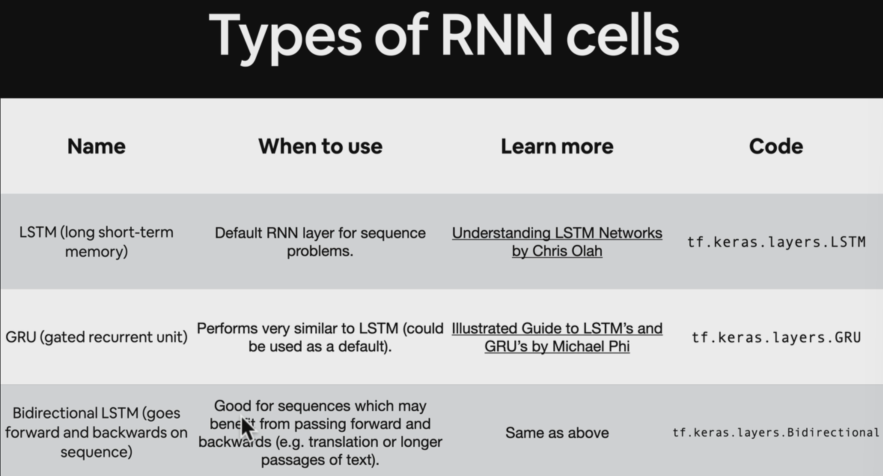

In [103]:
# Set random seed
tf.random.set_seed(42)

# Create the inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Passing the input text to tokenization layer to convert from string into number
tokenization = layers.TextVectorization(max_tokens=10000,
                                       output_sequence_length=15)

# Fit the tokenization layer (adapt)
tokenization.adapt(train_sentences)

# Pass the inputs into tokenization layer
x = tokenization(inputs)

# Pass the tokenized text (number) into embedding layer
embedding = layers.Embedding(input_dim=10000,
                            output_dim=128,
                            input_length=15)
x = embedding(x)

# Create Conv 1D and pooling layer
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)

# Create the outputs
outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

# Pass the input into Model
model_5 = tf.keras.Model(inputs, outputs)

# Compile the model
model_5.compile(optimizer=Adam(),
               loss=BinaryCrossentropy(),
               metrics='accuracy')

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('NLP/model_5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='NLP/model_5/model_5.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Fit the model
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              validation_data=(test_sentences, test_labels),
                              callbacks=[tensorboard, checkpoint])

Epoch 1/10
215/215 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7214
Epoch 00001: val_accuracy improved from -inf to 0.77690, saving model to NLP/model_5\model_5.ckpt
INFO:tensorflow:Assets written to: NLP/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_5\model_5.ckpt\assets


215/215 [==============================] - 5s 20ms/step - loss: 0.5559 - accuracy: 0.7214 - val_loss: 0.4665 - val_accuracy: 0.7769
Epoch 2/10
211/215 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8643
Epoch 00002: val_accuracy improved from 0.77690 to 0.78215, saving model to NLP/model_5\model_5.ckpt
INFO:tensorflow:Assets written to: NLP/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_5\model_5.ckpt\assets


215/215 [==============================] - 3s 16ms/step - loss: 0.3323 - accuracy: 0.8644 - val_loss: 0.4799 - val_accuracy: 0.7822
Epoch 3/10
214/215 [============================>.] - ETA: 0s - loss: 0.2038 - accuracy: 0.9225
Epoch 00003: val_accuracy did not improve from 0.78215
215/215 [==============================] - 2s 8ms/step - loss: 0.2038 - accuracy: 0.9225 - val_loss: 0.5586 - val_accuracy: 0.7677
Epoch 4/10
213/215 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9592
Epoch 00004: val_accuracy did not improve from 0.78215
215/215 [==============================] - 2s 9ms/step - loss: 0.1280 - accuracy: 0.9591 - val_loss: 0.6447 - val_accuracy: 0.7677
Epoch 5/10
210/215 [============================>.] - ETA: 0s - loss: 0.0899 - accuracy: 0.9696
Epoch 00005: val_accuracy improved from 0.78215 to 0.78871, saving model to NLP/model_5\model_5.ckpt
INFO:tensorflow:Assets written to: NLP/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_5\model_5.ckpt\assets


215/215 [==============================] - 3s 15ms/step - loss: 0.0901 - accuracy: 0.9696 - val_loss: 0.7039 - val_accuracy: 0.7887
Epoch 6/10
209/215 [============================>.] - ETA: 0s - loss: 0.0774 - accuracy: 0.9735
Epoch 00006: val_accuracy did not improve from 0.78871
215/215 [==============================] - 2s 8ms/step - loss: 0.0792 - accuracy: 0.9731 - val_loss: 0.7249 - val_accuracy: 0.7664
Epoch 7/10
209/215 [============================>.] - ETA: 0s - loss: 0.0631 - accuracy: 0.9773
Epoch 00007: val_accuracy did not improve from 0.78871
215/215 [==============================] - 2s 8ms/step - loss: 0.0626 - accuracy: 0.9772 - val_loss: 0.7781 - val_accuracy: 0.7651
Epoch 8/10
211/215 [============================>.] - ETA: 0s - loss: 0.0595 - accuracy: 0.9775
Epoch 00008: val_accuracy did not improve from 0.78871
215/215 [==============================] - 2s 8ms/step - loss: 0.0602 - accuracy: 0.9772 - val_loss: 0.7967 - val_accuracy: 0.7703
Epoch 9/10
214/215 [==

In [104]:
model_5.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_18 (Text  (None, 15)               0         
 Vectorization)                                                  
                                                                 
 embedding_19 (Embedding)    (None, 15, 128)           1280000   
                                                                 
 conv1d_12 (Conv1D)          (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 output_layer (Dense)        (None, 1)                 65 

In [87]:
embedding_test = embedding(tokenization(['this is test sentence']))
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04205751, -0.05478559, -0.04983784, ...,  0.00425127,
         -0.01876421, -0.07647008],
        [-0.03843315,  0.05552648,  0.02051948, ...,  0.04225523,
          0.04862639,  0.02822519],
        [ 0.07669727,  0.00904086,  0.01000767, ...,  0.07024672,
         -0.01430926,  0.05697757],
        ...,
        [ 0.03807857, -0.06320497,  0.01991673, ..., -0.10531484,
          0.09003447,  0.03850365],
        [ 0.03807857, -0.06320497,  0.01991673, ..., -0.10531484,
          0.09003447,  0.03850365],
        [ 0.03807857, -0.06320497,  0.01991673, ..., -0.10531484,
          0.09003447,  0.03850365]]], dtype=float32)>

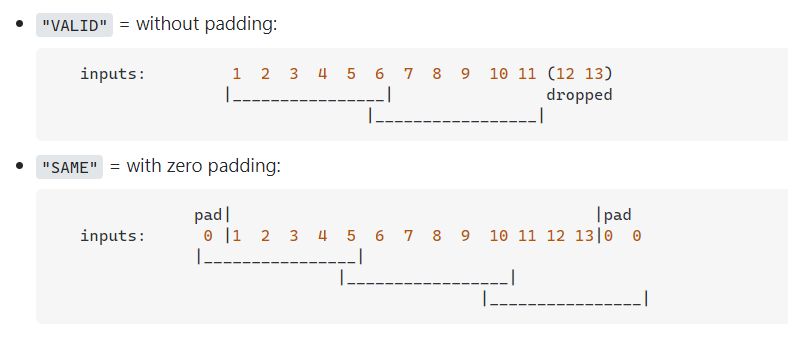

In [96]:
conv_1d = layers.Conv1D(filters=32,
                       kernel_size=5, # reffered as ngram of 5, 5 sentence at once
                       strides=1, # default
                       padding='valid', # default='valid' output size smaller than the input
                       activation='relu') 
conv_1d_output = conv_1d(embedding_test)
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.03429395, 0.08785287, 0.        , 0.08403197, 0.        ,
         0.        , 0.08271834, 0.        , 0.        , 0.05645183,
         0.03816933, 0.        , 0.10076078, 0.        , 0.        ,
         0.04709551, 0.        , 0.03141707, 0.00842093, 0.        ,
         0.01701245, 0.02838836, 0.11405595, 0.05105507, 0.05722909,
         0.        , 0.        , 0.05490864, 0.08303034, 0.02703114,
         0.06960148, 0.        ],
        [0.02403763, 0.02738313, 0.        , 0.0332731 , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.01881375,
         0.05515362, 0.08265562, 0.05440781, 0.        , 0.02730319,
         0.01994331, 0.1675683 , 0.0403367 , 0.01066262, 0.        ,
         0.        , 0.0062034 , 0.07080049, 0.00551632, 0.        ,
         0.        , 0.        , 0.06046486, 0.02090205, 0.        ,
         0.19359328, 0.        ],
        [0.05012833, 0.05462136, 0.        , 0.0848

In [97]:
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.0607689 , 0.08785287, 0.        , 0.08484332, 0.        ,
        0.        , 0.08271834, 0.01749439, 0.        , 0.07125738,
        0.14891984, 0.09931765, 0.10076078, 0.04184759, 0.05008287,
        0.04709551, 0.1675683 , 0.0403367 , 0.03324378, 0.        ,
        0.01701245, 0.07295305, 0.11405595, 0.05105507, 0.07480919,
        0.00934316, 0.        , 0.06046486, 0.08303034, 0.02703114,
        0.21729904, 0.        ]], dtype=float32)>

In [98]:
tf.math.reduce_max(conv_1d_output, axis=1)

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.0607689 , 0.08785287, 0.        , 0.08484332, 0.        ,
        0.        , 0.08271834, 0.01749439, 0.        , 0.07125738,
        0.14891984, 0.09931765, 0.10076078, 0.04184759, 0.05008287,
        0.04709551, 0.1675683 , 0.0403367 , 0.03324378, 0.        ,
        0.01701245, 0.07295305, 0.11405595, 0.05105507, 0.07480919,
        0.00934316, 0.        , 0.06046486, 0.08303034, 0.02703114,
        0.21729904, 0.        ]], dtype=float32)>

In [105]:
model_5.evaluate(test_sentences, test_labels)

24/24 [==============================] - 0s 7ms/step - loss: 0.8716 - accuracy: 0.7743


[0.8715895414352417, 0.7742782235145569]

In [109]:
model_5_pred = np.round(model_5.predict(test_sentences))

In [110]:
print(classification_report(test_labels, model_5_pred))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81       414
           1       0.84      0.63      0.72       348

    accuracy                           0.77       762
   macro avg       0.79      0.76      0.76       762
weighted avg       0.78      0.77      0.77       762



### Tensorflow Hub

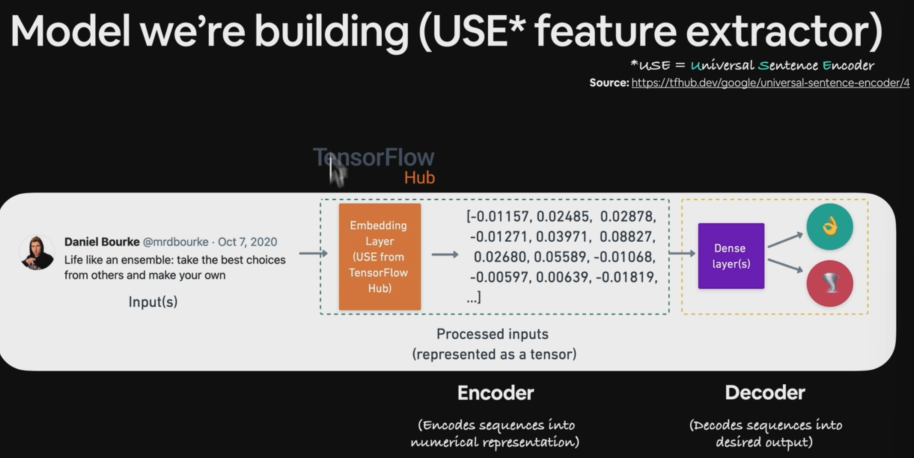

In [16]:
embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                            trainable=False,
                            dtype=tf.string,
                            input_shape=[])

In [17]:
# Create a model
tf.random.set_seed(42)

model_6 = Sequential([
    embedding,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [18]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [47]:
# Compile the model
model_6.compile(loss=BinaryCrossentropy(),
               metrics='accuracy',
               optimizer=Adam())

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('NLP/model_6')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='NLP/model_6/model_6.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Fit the model
history_model_6 = model_6.fit(train_sentences, 
                             train_labels,
                             epochs=10,
                             validation_data=(test_sentences, test_labels),
                             callbacks=[tensorboard, checkpoint])

Epoch 1/10
213/215 [============================>.] - ETA: 0s - loss: 0.4254 - accuracy: 0.8075
Epoch 00001: val_accuracy improved from -inf to 0.80577, saving model to NLP/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


215/215 [==============================] - 12s 49ms/step - loss: 0.4251 - accuracy: 0.8078 - val_loss: 0.4279 - val_accuracy: 0.8058
Epoch 2/10
213/215 [============================>.] - ETA: 0s - loss: 0.4024 - accuracy: 0.8229
Epoch 00002: val_accuracy did not improve from 0.80577
215/215 [==============================] - 3s 14ms/step - loss: 0.4023 - accuracy: 0.8228 - val_loss: 0.4220 - val_accuracy: 0.8058
Epoch 3/10
213/215 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8273
Epoch 00003: val_accuracy improved from 0.80577 to 0.81365, saving model to NLP/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


215/215 [==============================] - 10s 47ms/step - loss: 0.3909 - accuracy: 0.8275 - val_loss: 0.4208 - val_accuracy: 0.8136
Epoch 4/10
214/215 [============================>.] - ETA: 0s - loss: 0.3839 - accuracy: 0.8289
Epoch 00004: val_accuracy improved from 0.81365 to 0.81496, saving model to NLP/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


215/215 [==============================] - 9s 42ms/step - loss: 0.3838 - accuracy: 0.8289 - val_loss: 0.4186 - val_accuracy: 0.8150
Epoch 5/10
212/215 [============================>.] - ETA: 0s - loss: 0.3756 - accuracy: 0.8374
Epoch 00005: val_accuracy improved from 0.81496 to 0.81627, saving model to NLP/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


215/215 [==============================] - 9s 43ms/step - loss: 0.3770 - accuracy: 0.8367 - val_loss: 0.4219 - val_accuracy: 0.8163
Epoch 6/10
213/215 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.8385
Epoch 00006: val_accuracy improved from 0.81627 to 0.82021, saving model to NLP/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


215/215 [==============================] - 10s 45ms/step - loss: 0.3696 - accuracy: 0.8384 - val_loss: 0.4176 - val_accuracy: 0.8202
Epoch 7/10
213/215 [============================>.] - ETA: 0s - loss: 0.3634 - accuracy: 0.8405
Epoch 00007: val_accuracy did not improve from 0.82021
215/215 [==============================] - 3s 13ms/step - loss: 0.3630 - accuracy: 0.8408 - val_loss: 0.4182 - val_accuracy: 0.8202
Epoch 8/10
215/215 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8429
Epoch 00008: val_accuracy improved from 0.82021 to 0.82415, saving model to NLP/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


INFO:tensorflow:Assets written to: NLP/model_6\model_6.ckpt\assets


215/215 [==============================] - 9s 43ms/step - loss: 0.3559 - accuracy: 0.8429 - val_loss: 0.4186 - val_accuracy: 0.8241
Epoch 9/10
212/215 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8496
Epoch 00009: val_accuracy did not improve from 0.82415
215/215 [==============================] - 3s 14ms/step - loss: 0.3484 - accuracy: 0.8494 - val_loss: 0.4221 - val_accuracy: 0.8215
Epoch 10/10
213/215 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8518
Epoch 00010: val_accuracy did not improve from 0.82415
215/215 [==============================] - 3s 13ms/step - loss: 0.3414 - accuracy: 0.8520 - val_loss: 0.4232 - val_accuracy: 0.8215


In [2]:
model_6_best = load_model('NLP/model_6/model_6.ckpt/')

In [20]:
model_6_best.evaluate(test_sentences, test_labels)

24/24 [==============================] - 2s 12ms/step - loss: 0.4186 - accuracy: 0.8241


[0.4185837507247925, 0.8241469860076904]

In [21]:
model_6_pred = np.round(model_6_best.predict(test_sentences))

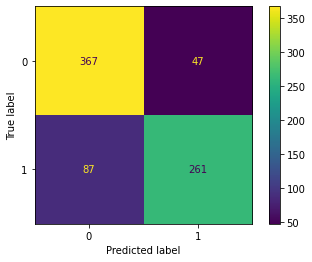

In [22]:
ConfusionMatrixDisplay.from_predictions(test_labels, model_6_pred);

In [23]:
print(classification_report(test_labels, model_6_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       414
           1       0.85      0.75      0.80       348

    accuracy                           0.82       762
   macro avg       0.83      0.82      0.82       762
weighted avg       0.83      0.82      0.82       762



## 6.5 Finding most wrong examples

In [235]:
test_sentences[:10], len(test_sentences), test_sentences.shape

(array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
        'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
        'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
        "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over so

In [252]:
test_sentences.squeeze()[:10]

array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
       'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
       'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
       '@camilacabello97 Internally and externally screaming',
       'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
       'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
       'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
       "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern C

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
%matplotlib inline
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential, load_model, clone_model
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14882326695689468051
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2252026676
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3670777078077918487
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [226]:
test_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [229]:
pred_prob = model_6_best.predict(test_sentences)
pred_prob[:10]

array([[0.14545639],
       [0.7985526 ],
       [0.998713  ],
       [0.2512985 ],
       [0.6999143 ],
       [0.7747675 ],
       [0.99437404],
       [0.99087673],
       [0.97436124],
       [0.06605393]], dtype=float32)

In [231]:
pred_bool = np.round(pred_prob)
pred_bool[:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [260]:
pred_df = pd.DataFrame(data={'text':test_sentences.squeeze(),
                             'pred':pred_bool.squeeze(),
                             'label':test_labels.squeeze(),
                             'probs':np.round(pred_prob.squeeze(), 2),
                             'true_or_false':pred_bool.squeeze()==test_labels.squeeze()})

In [262]:
pred_df['pred'] = pred_df['pred'].astype('int')

In [263]:
pred_df.head()

text  pred  label  probs  \
0  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...     0      0   0.15   
1  FedEx no longer to transport bioterror germs i...     1      0   0.80   
2  Gunmen kill four in El Salvador bus attack: Su...     1      1   1.00   
3  @camilacabello97 Internally and externally scr...     0      1   0.25   
4  Radiation emergency #preparedness starts with ...     1      1   0.70   

   true_or_false  
0           True  
1          False  
2           True  
3          False  
4           True

In [266]:
wrong_sorted_df = pred_df[pred_df['true_or_false']==False].sort_values(by='probs', ascending=False)

In [280]:
wrong_sorted_df[:10]

text  pred  label  probs  \
628  @noah_anyname That's where the concentration c...     1      0   0.93   
31   ? High Skies - Burning Buildings ? http://t.co...     1      0   0.92   
109  [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...     1      0   0.91   
759  FedEx will no longer transport bioterror patho...     1      0   0.90   
381                    Deaths 3 http://t.co/nApviyGKYK     1      0   0.87   
251  @AshGhebranious civil rights continued in the ...     1      0   0.86   
303  Trafford Centre film fans angry after Odeon ci...     1      0   0.86   
49   @madonnamking RSPCA site multiple 7 story high...     1      0   0.84   
393  @SonofLiberty357 all illuminated by the bright...     1      0   0.84   
209  Ashes 2015: AustraliaÛªs collapse at Trent Br...     1      0   0.84   

     true_or_false  
628          False  
31           False  
109          False  
759          False  
381          False  
251          False  
303          False  
49           False  
393          False  
209          False

In [298]:
wrong_sorted_df['text'].values[0]

"@noah_anyname That's where the concentration camps and mass murder come in. \n \nEVERY. FUCKING. TIME."

In [315]:
for i in range(10):
    print(f"""
    Actual: {wrong_sorted_df['label'].values[i]}, Pred: {wrong_sorted_df['pred'].values[i]}, Probs: {round(wrong_sorted_df['probs'].values[i]*100,1)}%
    Text: {wrong_sorted_df['text'].values[i]}\n
    ------------
    """)


    Actual: 0, Pred: 1, Probs: 93.0%
    Text: @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

    ------------
    

    Actual: 0, Pred: 1, Probs: 92.0%
    Text: ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

    ------------
    

    Actual: 0, Pred: 1, Probs: 91.0%
    Text: [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

    ------------
    

    Actual: 0, Pred: 1, Probs: 90.0%
    Text: FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

    ------------
    

    Actual: 0, Pred: 1, Probs: 87.0%
    Text: Deaths 3 http://t.co/nApviyGKYK

    ------------
    

    Actual: 0, Pred: 1, Probs: 86.0%
    Text: @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

    ------------
    

 

In [314]:
for i in range(124, 134):
    print(f"""
    Actual: {wrong_sorted_df['label'].values[i]}, Pred: {wrong_sorted_df['pred'].values[i]}, Probs: {round(wrong_sorted_df['probs'].values[i]*100,1)}%
    Text: {wrong_sorted_df['text'].values[i]}\n
    ----------
    """)


    Actual: 1, Pred: 0, Probs: 6.0%
    Text: New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

    ----------
    

    Actual: 1, Pred: 0, Probs: 5.0%
    Text: @DavidVonderhaar At least you were sincere ??

    ----------
    

    Actual: 1, Pred: 0, Probs: 5.0%
    Text: VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

    ----------
    

    Actual: 1, Pred: 0, Probs: 5.0%
    Text: Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

    ----------
    

    Actual: 1, Pred: 0, Probs: 5.0%
    Text: going to redo my nails and watch behind the scenes of desolation of smaug ayyy

    ----------
    

    Actual: 1, Pred: 0, Probs: 4.0%
    Text: You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like yo

In [316]:
test_df.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [318]:
test_sentences_2 = test_df['text'].to_numpy()
test_sentences_2, len(test_sentences_2)

(array(['Just happened a terrible car crash',
        'Heard about #earthquake is different cities, stay safe everyone.',
        'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
        ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
        'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
        '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
       dtype=object),
 3263)

In [319]:
test_probs = np.round(model_6_best.predict(test_sentences_2),2)
test_preds = np.round(test_probs)
test_probs[:10], test_preds[:10]

(array([[0.58],
        [0.92],
        [0.85],
        [0.96],
        [0.99],
        [0.51],
        [0.07],
        [0.03],
        [0.04],
        [0.05]], dtype=float32),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32))

In [322]:
for i in range(10):
    print(f"""
    Pred: {int(test_preds.squeeze()[i])}, Probs: {round(test_probs.squeeze()[i]*100,1)}%
    Text: {test_sentences_2[i]}\n
    ----------
    """)


    Pred: 1, Probs: 58.0%
    Text: Just happened a terrible car crash

    ----------
    

    Pred: 1, Probs: 92.0%
    Text: Heard about #earthquake is different cities, stay safe everyone.

    ----------
    

    Pred: 1, Probs: 85.0%
    Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all

    ----------
    

    Pred: 1, Probs: 96.0%
    Text: Apocalypse lighting. #Spokane #wildfires

    ----------
    

    Pred: 1, Probs: 99.0%
    Text: Typhoon Soudelor kills 28 in China and Taiwan

    ----------
    

    Pred: 1, Probs: 51.0%
    Text: We're shaking...It's an earthquake

    ----------
    

    Pred: 0, Probs: 7.0%
    Text: They'd probably still show more life than Arsenal did yesterday, eh? EH?

    ----------
    

    Pred: 0, Probs: 3.0%
    Text: Hey! How are you?

    ----------
    

    Pred: 0, Probs: 4.0%
    Text: What a nice hat?

    ----------
    

    Pred: 0, Probs: 5.0%
    Text: Fuck off!

    ---

In [329]:
np.round(model_6_best.predict(["Cop26: Why we need to act now on climate change"]))[0][0]

1.0

## 3.7 Tweets predicting from the wild

In [366]:
import time
def pred_tweets(tweet):
    start_time = time.perf_counter() # Get start_time
    probs = model_6_best.predict([tweet])
    end_time = time.perf_counter() # Get finish time
    total_time = end_time - start_time
    pred = int(np.round(probs)[0][0])
    if pred == 1:
        pred = 'Disaster'
    else:
        pred = 'Not Disaster'
    print(f"""
    Tweets: {tweet}
    Pred: {pred}
    Probs: {np.round(probs[0][0]*100, 2)} %
    """)

In [370]:
pred_tweets('Water flowing over the city last night')


    Tweets: Water flowing over the city last night
    Pred: Disaster
    Probs: 62.18 %
    


In [358]:
import time
def timer_tweets(tweet):
    start_time = time.perf_counter() # Get start_time
    probs = model_6_best.predict([tweet])
    end_time = time.perf_counter() # Get finish time
    total_time = end_time - start_time
    print(f"""
    Total time: {total_time} s
    Time per samples: {total_time/len(tweet)} s
    How many samples: {len(tweet)}
    """)

In [359]:
timer_tweets(test_sentences_2)


    Total time: 1.7258772999994108 s
    Time per samples: 0.0005289234753292709 s
    How many samples: 3263
    


In [364]:
3*1e-5/0.024

0.0012500000000000002

## 3.8 SkimLit (Skim Literature) on PubMed

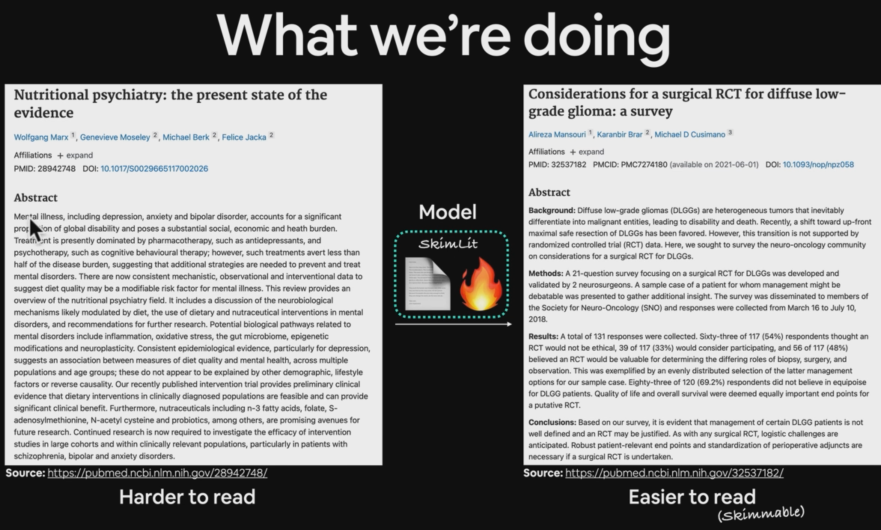

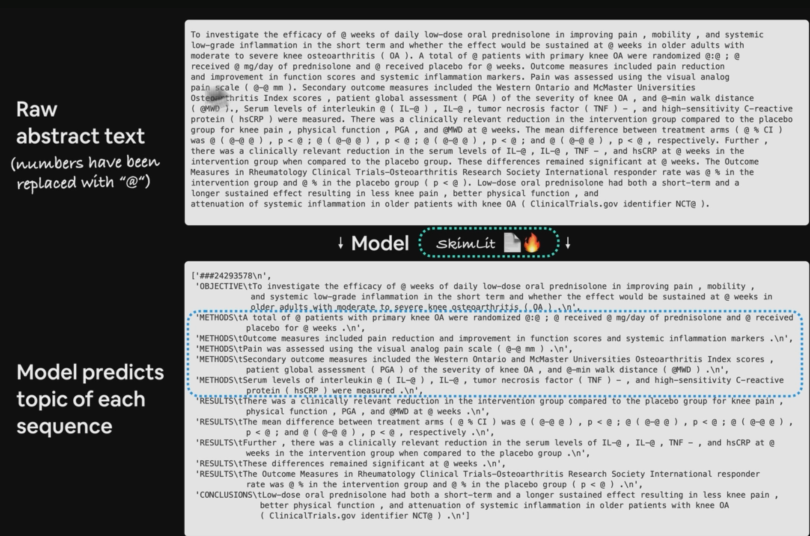

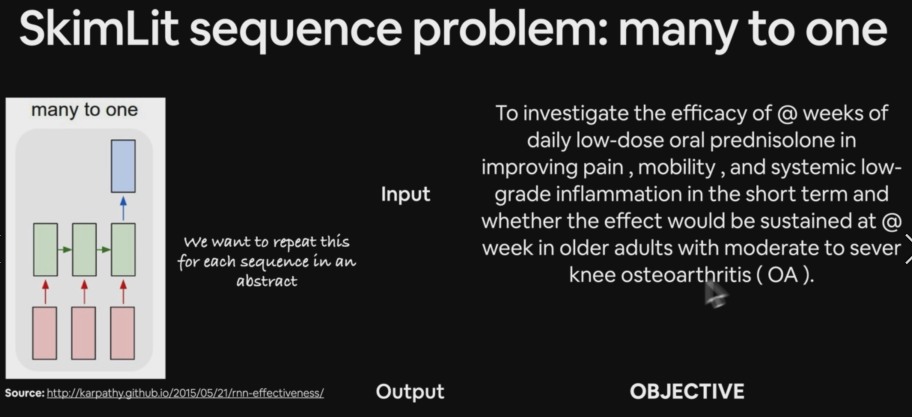

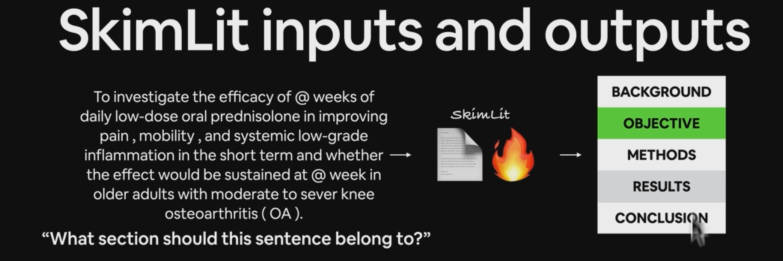

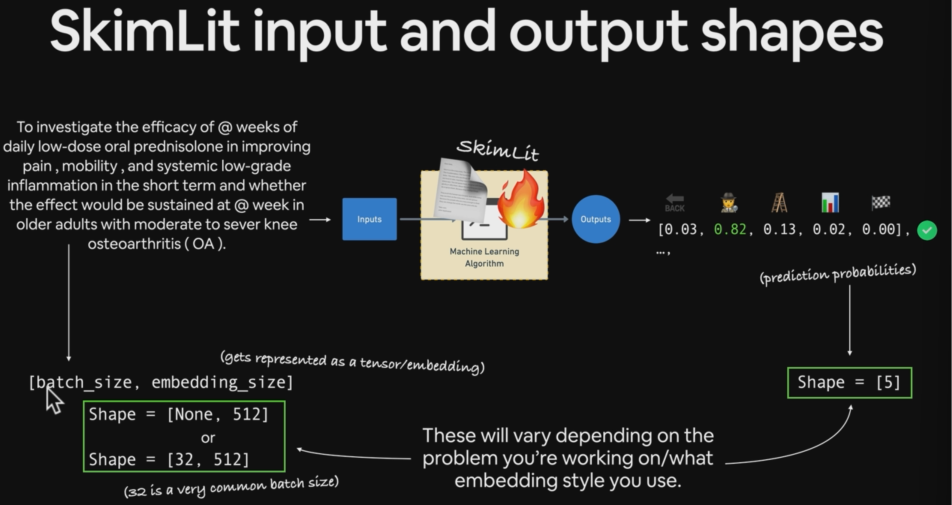

### Becoming one of the data

In [2]:
train_dir = 'pubmed_train_with_sign_20k.txt'

In [3]:
def get_lines(filename):
    """
    Read text filename and returns the lines of texts as a list
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [4]:
train_lines = get_lines(train_dir)

In [5]:
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
len(train_lines)

210040

### Let's think about how we want our data to look

How I think our data would be represented is

```
[{'line_number':0,
   'target': 'BACKGROUND'
    'text': "Emotional eating is associated with 
    overeating and the development of obesity."
    'total_lines': 11},
    ....]  
```

### Let's create a function

In [7]:
def preprocess_text(directory):
    """
    Returns a list of dictionaries of abstract line data
    """
    input_lines = get_lines(directory) # Get all lines from directory
    abstract_lines = '' # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstract
    
    # Iterate through each line in the target file
    for lines in input_lines:
        if lines.startswith('###'):
            absract_id = lines
            abstract_lines = '' # Reset the abstract string if the line is id line
            
        elif lines.isspace():
            abstract_lines_split = abstract_lines.splitlines() # Split abstract into separate items
            
            # Iterate through each line in a single abstract and count them
            for i, line in enumerate(abstract_lines_split):
                line_data = {} # Create an empty dictionary
                target_text_split = line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower() 
                line_data['line_number'] = i
                line_data['total_lines'] = len(abstract_lines_split)-1 # Start from 0
                abstract_samples.append(line_data)
            
        else: # The line contains a labelled sentence
            abstract_lines += lines
    
    return abstract_samples

In [8]:
%%time
train_samples = preprocess_text(directory=train_dir)

Wall time: 477 ms


In [9]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
def text_readlines(directory):
    with open(directory, mode='r') as f:
        return f.readlines()

def text_preprocess(directory):
    list_text = text_readlines(directory)
    
    sentences = ''
    list_of_dict = []
    
    for text in list_text:
        if text.startswith('###'): # change the number id into ''
            sentences = ''
            
        elif text.isspace(): # if there is a space ('\t', '\n')
            text_split = sentences.splitlines()
            for i, text in enumerate(text_split):
                text_dict = {}
                target = text.split('\t')[0]
                text = text.split('\t')[1]
                text_dict['target'] = target
                text_dict['text'] = text
                text_dict['line_number'] = i
                text_dict['total_line'] = len(text_split)-1
                list_of_dict.append(text_dict)
        else:
            sentences += text

    return list_of_dict
        

In [11]:
train_sentences = text_preprocess('pubmed_train_with_sign_20k.txt')
train_sentences[:5]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_line': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontario an

In [12]:
test_sentences = text_preprocess('pubmed_test_with_sign_20k.txt')
val_sentences = text_preprocess('pubmed_validation_with_sign_20k.txt')

In [13]:
test_sentences[:15]

[{'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
  'line_number': 0,
  'total_line': 8},
 {'target': 'RESULTS',
  'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
  'line_number': 1,
  'total_line': 8},
 {'target': 'RESULTS',
  'text': 'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'line_number': 2,
  'total_line': 8},
 {'target': 'RESULTS',
  'text': 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , 

In [14]:
val_sentences[:2]

[{'target': 'BACKGROUND',
  'text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_line': 9},
 {'target': 'BACKGROUND',
  'text': 'It is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_line': 9}]

In [15]:
len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [16]:
train_sentences[180039]['target']

'CONCLUSIONS'

In [17]:
train_df = pd.DataFrame(train_sentences)
test_df = pd.DataFrame(test_sentences)
val_sentences = pd.DataFrame(val_sentences)

In [18]:
train_df[:15]

target                                               text  \
0     OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
1       METHODS  A total of @ patients with primary knee OA wer...   
2       METHODS  Outcome measures included pain reduction and i...   
3       METHODS  Pain was assessed using the visual analog pain...   
4       METHODS  Secondary outcome measures included the Wester...   
5       METHODS  Serum levels of interleukin @ ( IL-@ ) , IL-@ ...   
6       RESULTS  There was a clinically relevant reduction in t...   
7       RESULTS  The mean difference between treatment arms ( @...   
8       RESULTS  Further , there was a clinically relevant redu...   
9       RESULTS  These differences remained significant at @ we...   
10      RESULTS  The Outcome Measures in Rheumatology Clinical ...   
11  CONCLUSIONS  Low-dose oral prednisolone had both a short-te...   
12   BACKGROUND  Emotional eating is associated with overeating...   
13   BACKGROUND  Yet , empirical evidence for individual ( trai...   
14    OBJECTIVE  The aim of this study was to test if attention...   

    line_number  total_line  
0             0          11  
1             1          11  
2             2          11  
3             3          11  
4             4          11  
5             5          11  
6             6          11  
7             7          11  
8             8          11  
9             9          11  
10           10          11  
11           11          11  
12            0          10  
13            1          10  
14            2          10

In [19]:
train_df_dummies = pd.get_dummies(train_df, columns=['target'])
train_df_dummies.head()

text  line_number  total_line  \
0  To investigate the efficacy of @ weeks of dail...            0          11   
1  A total of @ patients with primary knee OA wer...            1          11   
2  Outcome measures included pain reduction and i...            2          11   
3  Pain was assessed using the visual analog pain...            3          11   
4  Secondary outcome measures included the Wester...            4          11   

   target_BACKGROUND  target_CONCLUSIONS  target_METHODS  target_OBJECTIVE  \
0                  0                   0               0                 1   
1                  0                   0               1                 0   
2                  0                   0               1                 0   
3                  0                   0               1                 0   
4                  0                   0               1                 0   

   target_RESULTS  
0               0  
1               0  
2               0  
3               0  
4               0

In [20]:
train_df_dummies.columns

Index(['text', 'line_number', 'total_line', 'target_BACKGROUND',
       'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE',
       'target_RESULTS'],
      dtype='object')

In [21]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

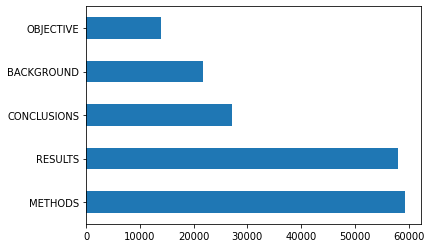

In [22]:
train_df.target.value_counts().plot.barh();

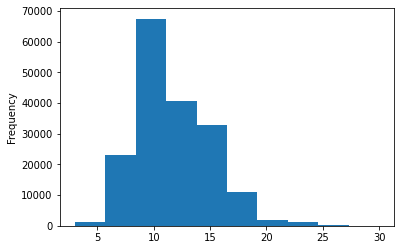

In [23]:
train_df.total_line.plot.hist();

### Create baseline (Naive Bayes)

In [24]:
train_texts = train_df.text.to_numpy()
train_labels = np.argmax(train_df_dummies[['target_BACKGROUND', 'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE', 'target_RESULTS']].to_numpy(), axis=1)

In [25]:
train_texts[:2]

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'],
      dtype=object)

In [26]:
train_labels[:2]

array([3, 2], dtype=int64)

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [28]:
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

In [29]:
len(train_texts), len(test_texts), len(train_labels), len(test_labels)

(162036, 18004, 162036, 18004)

In [33]:
# Set random seed
np.random.seed(42)

# Create a model
baseline_model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('naive', MultinomialNB())
])

# Fit a model
baseline_model.fit(train_texts, train_labels)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('naive', MultinomialNB())])

In [34]:
baseline_model.score(test_texts, test_labels)

0.7146745167740503

In [35]:
baseline_pred = baseline_model.predict(test_texts)
baseline_pred[:5]

array([4, 2, 1, 2, 4], dtype=int64)

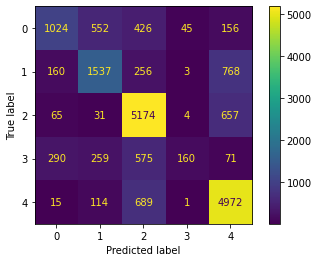

In [36]:
ConfusionMatrixDisplay.from_predictions(test_labels, baseline_pred)

In [79]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [80]:
def calculate_results_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    result = {'accuracy': np.round(accuracy,2),
             'precision': np.round(precision, 2),
             'recall': np.round(recall, 2),
             'f1_score': np.round(f1_score, 2)}
    return result

In [39]:
baseline_result_20k = calculate_results_model(test_labels, baseline_pred)

In [40]:
baseline_result_20k

{'accuracy': 0.71, 'precision': 0.71, 'recall': 0.71, 'f1_score': 0.69}

### Conv 1D

In [41]:
train_texts[:5]

array(['Some CM therapies have shown therapeutic effects for psoriasis vulgaris ( PV ) , including relieving symptoms and improving quality of life , and may reduce the relapse rate .',
       'Next , we utilized the National Health Interview Survey ( NHIS ) , which inquired about smoking history and race/ethnicity , to analyze the demographic profiles of various high-risk smoking history categories .',
       'We conducted a single-center , open-label , randomized controlled trial in which @ adult continuous ambulatory peritoneal dialysis patients underwent randomization to receive either icodextrin or original glucose-based dialysis solution .',
       'The in vitro higher activity of furamag versus cefotaxime was attended by the significantly higher eradication of one of the two important NUTI pathogens - Enterococcus faecalis .',
       'Although EW is feasible to use with persons who have CRC , it was not effective as a stand-alone psychotherapeutic intervention .'],
      dtype=o

In [42]:
# Create vectorization and embedding layer
vectorization_layer = layers.TextVectorization(max_tokens=10000,
                                              output_sequence_length=55)

# Fit the vectorization with train text
vectorization_layer.adapt(train_texts)

embedding_layer = layers.Embedding(input_dim=10000,
                                  output_dim=128,
                                  input_length=55)

In [43]:
embedding_layer(vectorization_layer(['i love you']))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.00228246,  0.0300565 ,  0.04460224, ...,  0.00570507,
         -0.03672886,  0.02480796],
        [ 0.01994037,  0.00091063,  0.04300145, ..., -0.02589672,
          0.03011891,  0.03164673],
        [ 0.01994037,  0.00091063,  0.04300145, ..., -0.02589672,
          0.03011891,  0.03164673],
        ...,
        [ 0.02251163,  0.03359786,  0.00535434, ..., -0.03297113,
         -0.00792644, -0.03025619],
        [ 0.02251163,  0.03359786,  0.00535434, ..., -0.03297113,
         -0.00792644, -0.03025619],
        [ 0.02251163,  0.03359786,  0.00535434, ..., -0.03297113,
         -0.00792644, -0.03025619]]], dtype=float32)>

In [44]:
# Average sentence length
sent_len = [len(sentence.split()) for sentence in train_texts]
np.mean(sent_len)

26.346182329852624

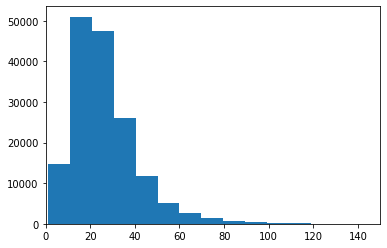

In [45]:
plt.hist(sent_len, bins=30)
plt.xlim(0, 150);

In [46]:
# How long of a sentence length covers 95% of examples
np.percentile(sent_len, q=95)

55.0

In [47]:
# Max length of sentences
np.max(sent_len)

296

In [71]:
# Create model, first set random seed
tf.random.set_seed(42)

# Set inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Pass the inputs into vectorization layer
vectorization_layer = layers.TextVectorization(max_tokens=68000,
                                              output_sequence_length=55)

vectorization_layer.adapt(train_texts)
x = vectorization_layer(inputs)


# Pass the vectorized text into embedding
embedding_layer = layers.Embedding(input_dim=68000,
                                  output_dim=128,
                                  input_length=55,
                                  mask_zero=True) # Use masking to handle variable sequence length

x = embedding_layer(x)

# Pass the embedded text into Conv1D
x = layers.Conv1D(filters=128, kernel_size=5)(x)

# Pass into feature extraction layer
x = layers.GlobalAveragePooling1D()(x)

# Set Dense layer
x = layers.Dense(128, activation='relu')(x)

# Set outputs
outputs = layers.Dense(5, activation='softmax')(x)

# Pass the input and output into model
model_1_20k = tf.keras.Model(inputs, outputs)

In [72]:
txt = vectorization_layer([['i love you'], ['i need you more']])
txt

<tf.Tensor: shape=(2, 55), dtype=int64, numpy=
array([[  390, 35605, 10186,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  390,   479, 10186,    69,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

In [73]:
embedding_layer(txt)

<tf.Tensor: shape=(2, 55, 128), dtype=float32, numpy=
array([[[-0.02324574,  0.01538433,  0.02566305, ..., -0.003272  ,
          0.01753011, -0.0460246 ],
        [ 0.04241527, -0.01383774, -0.0120963 , ..., -0.01788112,
         -0.01034928,  0.04191274],
        [ 0.04203708, -0.04550724, -0.01939513, ...,  0.03118275,
          0.02776464,  0.01483896],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]],

       [[-0.02324574,  0.01538433,  0.02566305, ..., -0.003272  ,
          0.01753011, -0.0460246 ],
        [ 0.04883992,  0.02300762,  0.04800229, ...,  0.00386858,
          0.04063806,  0.01405852],
        [ 0.04203708, -0.04550724, -0.01939513, ...,  0.03118275,
          0.02776464,  0.01483896],
        ...,


In [74]:
model_1_20k.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 55, 128)           8704000   
                                                                 
 conv1d_4 (Conv1D)           (None, 51, 128)           82048     
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               1651

In [75]:
# Compile the model
model_1_20k.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(),
                   metrics='accuracy')

# Create a callback
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='PubMed_20k/model_1')
checpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_1/model_1.ckpt',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              monitor='val_accuracy',
                                              verbose=1)

# Fit the model
history_1_20k = model_1_20k.fit(train_texts,
                               tf.cast(train_labels, dtype=tf.float32),
                               epochs=10,
                               validation_data=(test_texts, tf.cast(test_labels, dtype=tf.float32)),
                               callbacks=[tensorboard, checpoint])

Epoch 1/10
5064/5064 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.7738
Epoch 00001: val_accuracy improved from -inf to 0.80627, saving model to PubMed_20k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets
5064/5064 [==============================] - 71s 14ms/step - loss: 0.5988 - accuracy: 0.7738 - val_loss: 0.5288 - val_accuracy: 0.8063
Epoch 2/10
5063/5064 [============================>.] - ETA: 0s - loss: 0.4215 - accuracy: 0.8462
Epoch 00002: val_accuracy improved from 0.80627 to 0.81226, saving model to PubMed_20k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets
5064/5064 [==============================] - 72s 14ms/step - loss: 0.4214 - accuracy: 0.8462 - val_loss: 0.5210 - val_accuracy: 0.8123
Epoch 3/10
5062/5064 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8798
Epoch 00003: val_accuracy did not improve from 0.81226
5064/5064 [=========

### Creating datasets with tf.data (make training faster)

In [33]:
# Turn our data into Tensorflow Datasets
train_datasets_20k = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
test_datasets_20k = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))

In [34]:
train_datasets_20k

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [35]:
train_datasets_20k = train_datasets_20k.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
test_datasets_20k = test_datasets_20k.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
train_datasets_20k

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [132]:
# Create model, first set random seed
tf.random.set_seed(42)

# Set inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Pass the inputs into vectorization layer
vectorization_layer = layers.TextVectorization(max_tokens=68000,
                                              output_sequence_length=55)

vectorization_layer.adapt(train_texts)
x = vectorization_layer(inputs)


# Pass the vectorized text into embedding
embedding_layer = layers.Embedding(input_dim=68000,
                                  output_dim=128,
                                  input_length=55,
                                  mask_zero=True) # Use masking to handle variable sequence length

x = embedding_layer(x)

# Pass the embedded text into Conv1D
x = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(x) # Five word at once

# Pass into feature extraction layer
x = layers.GlobalMaxPool1D()(x)

# Set outputs
outputs = layers.Dense(5, activation='softmax')(x)

# Pass the input and output into model
model_1_20k = tf.keras.Model(inputs, outputs)

# Compile the model
model_1_20k.compile(loss=SparseCategoricalCrossentropy(),
                   optimizer=Adam(),
                   metrics='accuracy')

In [133]:
model_1_20k.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_9 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 55, 128)           8704000   
                                                                 
 conv1d_6 (Conv1D)           (None, 55, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 645 

In [134]:
len(train_datasets_20k)

5064

In [135]:
# Create a callback
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='PubMed_20k/model_1')
checpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_1/model_1.ckpt',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              monitor='val_accuracy',
                                              verbose=1)

# Fit the model
history_1_20k = model_1_20k.fit(train_datasets_20k,
                               steps_per_epoch=int(0.1*len(train_datasets_20k)),
                               epochs=5,
                               validation_data=test_datasets_20k,
                               validation_steps=int(0.1*len(test_datasets_20k)),
                               callbacks=[tensorboard, checpoint])

Epoch 1/5
503/506 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.6946
Epoch 00001: val_accuracy improved from -inf to 0.77232, saving model to PubMed_20k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


506/506 [==============================] - 12s 22ms/step - loss: 0.8080 - accuracy: 0.6953 - val_loss: 0.6299 - val_accuracy: 0.7723
Epoch 2/5
503/506 [============================>.] - ETA: 0s - loss: 0.5697 - accuracy: 0.7910
Epoch 00002: val_accuracy improved from 0.77232 to 0.79520, saving model to PubMed_20k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


506/506 [==============================] - 9s 17ms/step - loss: 0.5696 - accuracy: 0.7909 - val_loss: 0.5743 - val_accuracy: 0.7952
Epoch 3/5
504/506 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.8007
Epoch 00003: val_accuracy improved from 0.79520 to 0.79632, saving model to PubMed_20k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


506/506 [==============================] - 9s 17ms/step - loss: 0.5429 - accuracy: 0.8006 - val_loss: 0.5657 - val_accuracy: 0.7963
Epoch 4/5
503/506 [============================>.] - ETA: 0s - loss: 0.5402 - accuracy: 0.8018
Epoch 00004: val_accuracy improved from 0.79632 to 0.80357, saving model to PubMed_20k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_1\model_1.ckpt\assets


506/506 [==============================] - 9s 17ms/step - loss: 0.5392 - accuracy: 0.8023 - val_loss: 0.5540 - val_accuracy: 0.8036
Epoch 5/5
503/506 [============================>.] - ETA: 0s - loss: 0.5255 - accuracy: 0.8064
Epoch 00005: val_accuracy did not improve from 0.80357
506/506 [==============================] - 8s 15ms/step - loss: 0.5250 - accuracy: 0.8064 - val_loss: 0.5297 - val_accuracy: 0.8008


In [136]:
model_1_20k.evaluate(test_datasets_20k)

563/563 [==============================] - 4s 8ms/step - loss: 0.4974 - accuracy: 0.8181


[0.49738577008247375, 0.8180959820747375]

In [137]:
model_1_20k_pred = np.argmax(model_1_20k.predict(test_datasets_20k), axis=1)

In [138]:
model_1_20k_pred

array([4, 2, 0, ..., 1, 0, 2], dtype=int64)

In [139]:
model_1_20k_result = calculate_results_model(test_labels, model_1_20k_pred)

In [140]:
model_1_20k_result

{'accuracy': 0.82, 'precision': 0.82, 'recall': 0.82, 'f1_score': 0.82}

In [106]:
baseline_result_20k

{'accuracy': 0.71, 'precision': 0.71, 'recall': 0.71, 'f1_score': 0.69}

### Tensorflow Hub (Universal Sentence Encoder Model)
>GloVe is outdated so we're using USE

In [39]:
# Set vectorizer and embedding layer (using USE)
embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                trainable=False)

In [39]:
# Set random seed
tf.random.set_seed(42)

# Set inputs
inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')

# Passing the input into embedding layer
x = embedding_layer(inputs)

# Set dense layer
x = layers.Dense(128, activation='relu')(x)

# Set outputs
outputs = layers.Dense(5, activation='relu', name='output_layer')(x)

# Passing the inputs and outputs into Model
model_2_20k = tf.keras.Model(inputs, outputs)

In [40]:
model_2_20k.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [41]:
# Compile the model
model_2_20k.compile(loss=SparseCategoricalCrossentropy(),
                   optimizer=Adam(),
                   metrics='accuracy')

# Set the callbacks 
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_2')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_2/model_2.ckpt', 
                                               save_best_only=True, 
                                               save_weights_only=False,
                                               monitor='val_accuracy',
                                               verbose=1)

# Fit the model
history_2_20k = model_2_20k.fit(train_datasets_20k,
                               steps_per_epoch=int(0.1*len(train_datasets_20k)),
                               epochs=5,
                               validation_data=test_datasets_20k,
                               validation_steps=int(0.1*len(test_datasets_20k)),
                               callbacks=[tensorboard, checkpoint])

Epoch 1/5
506/506 [==============================] - ETA: 0s - loss: 1.3607 - accuracy: 0.5742
Epoch 00001: val_accuracy improved from -inf to 0.61440, saving model to PubMed_20k/model_2\model_2.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


506/506 [==============================] - 22s 39ms/step - loss: 1.3607 - accuracy: 0.5742 - val_loss: 1.2817 - val_accuracy: 0.6144
Epoch 2/5
505/506 [============================>.] - ETA: 0s - loss: 1.0946 - accuracy: 0.6157
Epoch 00002: val_accuracy improved from 0.61440 to 0.61998, saving model to PubMed_20k/model_2\model_2.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


506/506 [==============================] - 18s 36ms/step - loss: 1.0942 - accuracy: 0.6159 - val_loss: 1.1543 - val_accuracy: 0.6200
Epoch 3/5
505/506 [============================>.] - ETA: 0s - loss: 1.0979 - accuracy: 0.5854
Epoch 00003: val_accuracy did not improve from 0.61998
506/506 [==============================] - 10s 20ms/step - loss: 1.0980 - accuracy: 0.5850 - val_loss: 1.1379 - val_accuracy: 0.5809
Epoch 4/5
504/506 [============================>.] - ETA: 0s - loss: 1.0532 - accuracy: 0.6145
Epoch 00004: val_accuracy improved from 0.61998 to 0.64118, saving model to PubMed_20k/model_2\model_2.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


506/506 [==============================] - 18s 35ms/step - loss: 1.0520 - accuracy: 0.6151 - val_loss: 1.1567 - val_accuracy: 0.6412
Epoch 5/5
504/506 [============================>.] - ETA: 0s - loss: 1.0360 - accuracy: 0.6143
Epoch 00005: val_accuracy improved from 0.64118 to 0.64174, saving model to PubMed_20k/model_2\model_2.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_2\model_2.ckpt\assets


506/506 [==============================] - 18s 36ms/step - loss: 1.0359 - accuracy: 0.6146 - val_loss: 1.1557 - val_accuracy: 0.6417


In [42]:
model_2_20k = load_model('PubMed_20k/model_2/model_2.ckpt/')

In [43]:
model_2_20k.evaluate(test_datasets_20k)

563/563 [==============================] - 13s 22ms/step - loss: 1.0255 - accuracy: 0.64760s - loss: 1.0243 - accuracy


[1.025529146194458, 0.6475782990455627]

In [51]:
model_2_20k_pred = np.argmax(model_2_20k.predict(test_datasets_20k), axis=1)

In [52]:
model_2_20k_result = calculate_results_model(test_labels, model_2_20k_pred)

In [53]:
model_2_20k_result

{'accuracy': 0.65, 'precision': 0.65, 'recall': 0.65, 'f1_score': 0.62}

### Conv1D with character embedding

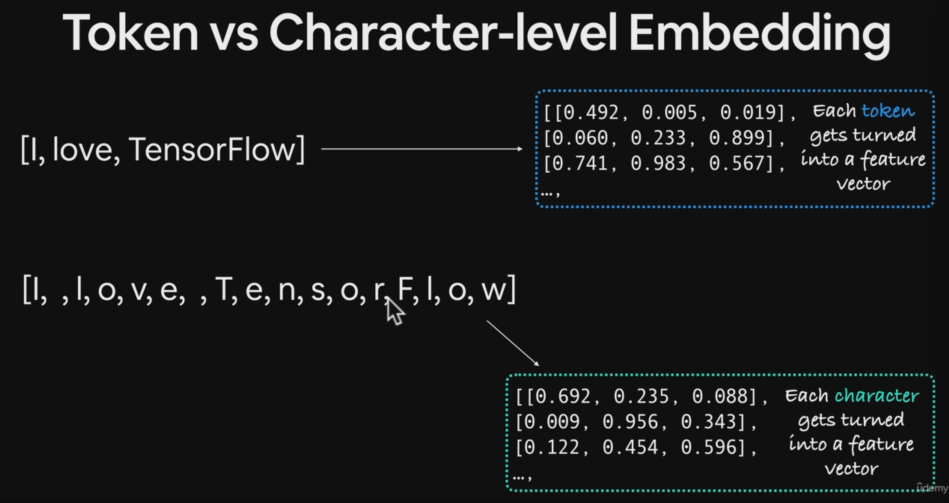

In [38]:
train_texts[0]

'Some CM therapies have shown therapeutic effects for psoriasis vulgaris ( PV ) , including relieving symptoms and improving quality of life , and may reduce the relapse rate .'

In [125]:
# Set random seed
tf.random.set_seed(42)

# Create inputs
inputs = layers.Input(shape=(1), dtype=tf.string, name='input_layer')

# Split the text into character level
def split_char(text):
    return ' '.join(text)

train_chars = [split_char(texts) for texts in train_texts]
test_chars = [split_char(texts) for texts in test_texts]

# Map the text and labels in tf data
train_data = tf.data.Dataset.from_tensor_slices((train_chars, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_chars, test_labels))

train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create vectorization layers (tokenizer)
vectorizer = layers.TextVectorization(max_tokens=28,
                                     output_sequence_length=290)

# Adapt the vectorizer
vectorizer.adapt(train_chars)

# Pass the input into vectorizer
x = vectorizer(inputs)

# Create the embedding layer
embedding = layers.Embedding(input_dim=28,
                            output_dim=25,
                            mask_zero=True,
                            input_length=290)

# Pass the vextorized text into embedding layer
x = embedding(x)

# Create Conv1D layer
x = layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x)

# Create a feature extraction layer
x = layers.GlobalMaxPool1D()(x)

# Create an outputs
outputs = layers.Dense(5, activation='softmax', name='output_layer')(x)

# Pass the outputs and inputs into Model
model_3_20k = tf.keras.Model(inputs, outputs)

In [126]:
train_data

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [127]:
model_3_20k.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_8 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_5 (Conv1D)           (None, 290, 128)          16128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)                 645 

In [128]:
# Compile the model
model_3_20k.compile(optimizer=Adam(),
                   loss=SparseCategoricalCrossentropy(),
                   metrics='accuracy')

# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_3')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_3/model_3.ckpt',
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False)

# Fit the model
history_3_20k = model_3_20k.fit(train_data,
                               epochs=5,
                               steps_per_epoch=int(0.1*len(train_data)),
                               validation_data=test_data,
                               validation_steps=int(0.1*len(test_data)),
                               callbacks=[tensorboard, checkpoint])

Epoch 1/5
503/506 [============================>.] - ETA: 0s - loss: 1.2311 - accuracy: 0.4975
Epoch 00001: val_accuracy improved from -inf to 0.60658, saving model to PubMed_20k/model_3\model_3.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


506/506 [==============================] - 7s 13ms/step - loss: 1.2297 - accuracy: 0.4980 - val_loss: 1.0299 - val_accuracy: 0.6066
Epoch 2/5
506/506 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.6331
Epoch 00002: val_accuracy improved from 0.60658 to 0.65625, saving model to PubMed_20k/model_3\model_3.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


506/506 [==============================] - 5s 10ms/step - loss: 0.9361 - accuracy: 0.6331 - val_loss: 0.8986 - val_accuracy: 0.6562
Epoch 3/5
506/506 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.6671
Epoch 00003: val_accuracy improved from 0.65625 to 0.66853, saving model to PubMed_20k/model_3\model_3.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


506/506 [==============================] - 5s 10ms/step - loss: 0.8532 - accuracy: 0.6671 - val_loss: 0.8615 - val_accuracy: 0.6685
Epoch 4/5
504/506 [============================>.] - ETA: 0s - loss: 0.8237 - accuracy: 0.6843
Epoch 00004: val_accuracy improved from 0.66853 to 0.68973, saving model to PubMed_20k/model_3\model_3.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_3\model_3.ckpt\assets


506/506 [==============================] - 5s 11ms/step - loss: 0.8230 - accuracy: 0.6848 - val_loss: 0.8208 - val_accuracy: 0.6897
Epoch 5/5
505/506 [============================>.] - ETA: 0s - loss: 0.7942 - accuracy: 0.6925
Epoch 00005: val_accuracy did not improve from 0.68973
506/506 [==============================] - 5s 9ms/step - loss: 0.7939 - accuracy: 0.6926 - val_loss: 0.7996 - val_accuracy: 0.6875


In [129]:
model_3_20k.evaluate(test_data)

563/563 [==============================] - 5s 8ms/step - loss: 0.7624 - accuracy: 0.7151


[0.7623897194862366, 0.7150633335113525]

In [130]:
model_3_20k_pred = np.argmax(model_3_20k.predict(test_data), axis=1)
model_3_20k_pred

array([1, 2, 0, ..., 1, 0, 2], dtype=int64)

In [131]:
calculate_results_model(test_labels, model_3_20k_pred)

{'accuracy': 0.72, 'precision': 0.71, 'recall': 0.72, 'f1_score': 0.71}

In [41]:
def split_char(text):
    return ' '.join(text)

In [44]:
train_chars = [split_char(texts) for texts in train_texts]
test_chars = [split_char(texts) for texts in train_texts]
train_chars[:2]

['S o m e   C M   t h e r a p i e s   h a v e   s h o w n   t h e r a p e u t i c   e f f e c t s   f o r   p s o r i a s i s   v u l g a r i s   (   P V   )   ,   i n c l u d i n g   r e l i e v i n g   s y m p t o m s   a n d   i m p r o v i n g   q u a l i t y   o f   l i f e   ,   a n d   m a y   r e d u c e   t h e   r e l a p s e   r a t e   .',
 'N e x t   ,   w e   u t i l i z e d   t h e   N a t i o n a l   H e a l t h   I n t e r v i e w   S u r v e y   (   N H I S   )   ,   w h i c h   i n q u i r e d   a b o u t   s m o k i n g   h i s t o r y   a n d   r a c e / e t h n i c i t y   ,   t o   a n a l y z e   t h e   d e m o g r a p h i c   p r o f i l e s   o f   v a r i o u s   h i g h - r i s k   s m o k i n g   h i s t o r y   c a t e g o r i e s   .']

In [96]:
vectorizer_2(['i l o v e y o u'])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 4, 12,  7, 21,  2, 19,  7, 16,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]], dtype=int64)>

In [55]:
char_length = [len(text) for text in train_texts]
np.mean(char_length)

149.40817472660396

In [56]:
train_texts[0]

'Some CM therapies have shown therapeutic effects for psoriasis vulgaris ( PV ) , including relieving symptoms and improving quality of life , and may reduce the relapse rate .'

In [57]:
char_length[:5]

[175, 210, 238, 179, 129]

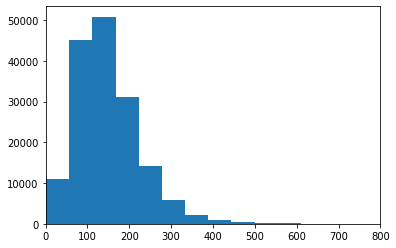

In [65]:
plt.hist(char_length, bins=25)
plt.xlim(0, 800);

In [66]:
np.percentile(char_length, q=95)

290.0

In [69]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [73]:
len(alphabet)

68

### Model with different inputs
Pretrained token embedding + character embedding

**How:**
1. Create a token-level embedding
2. Create a character-level embedding
3. Combine 1 & 2 with a 'layers.Concatenate'
4. Build a series of outputs layers on top of '3'
5. Construct a model which takes token and char-level sequences as input and produces sequence label probabilities as output

In [50]:
# Set vectorizer and embedding layer (using USE)
embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                trainable=False)

In [51]:
### 1 ### Create token-level embedding

# Set random seed
tf.random.set_seed(42)

# Set the token input
token_input = layers.Input(shape=[], dtype=tf.string, name='token_input_layer')

# Pass the token input into embedding layer
token_embedding = embedding_layer(token_input)

# Set the token output
token_output = layers.Dense(128, activation='relu')(token_embedding)

# Pass the input and output to Model
token_model = tf.keras.Model(token_input, token_output)



### 2 ### Create char-level embedding

# Create char inputs
char_input = layers.Input(shape=(1), dtype=tf.string, name='char_input_layer')

# Set the char-level vectorization
def split_char(text):
    return ' '.join(text)
train_char = [split_char(text) for text in train_texts]
test_char = [split_char(text) for text in test_texts]

vectorization_layer = layers.TextVectorization(max_tokens=28,
                                               output_sequence_length=239)
vectorization_layer.adapt(train_char)
char_vector = vectorization_layer(char_input)

# Set the char-level embedding
embedding_layer = layers.Embedding(input_dim=28,
                                  output_dim=128,
                                  input_length=239,
                                  mask_zero=True)
char_embed = embedding_layer(char_vector)

# Set the Conv1D layer
conv_1d = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(char_embed)

# Set the feature extraction
extraction = layers.GlobalMaxPool1D()(conv_1d)

# Set outputs
char_output = layers.Dense(128, activation='relu', name='char_output_Layer')(extraction)

# Pass the input and output into Model
char_model = tf.keras.Model(char_input, char_output)



### 3 ### Concatenate char-level and token-level embedding
token_char_concat = layers.Concatenate(name='token_char_concat_layer')([token_model.output,
                                                                       char_model.output])

### 4 ### Create output layer - adding dropouts
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation='softmax', name='final_output_layer')(final_dropout)

### 5 ### Construct model with char and token inputs
model_4_20k = tf.keras.Model(inputs=[token_model.input, char_model.input],
                            outputs=output_layer)

In [52]:
model_4_20k.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input_layer (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 239)         0           ['char_input_layer[0][0]']       
 orization)                                                                                       
                                                                                                  
 embedding_1 (Embedding)        (None, 239, 128)     3584        ['text_vectorization_1[0][0]']   
                                                                                                  
 token_input_layer (InputLayer)  [(None,)]           0           []                         

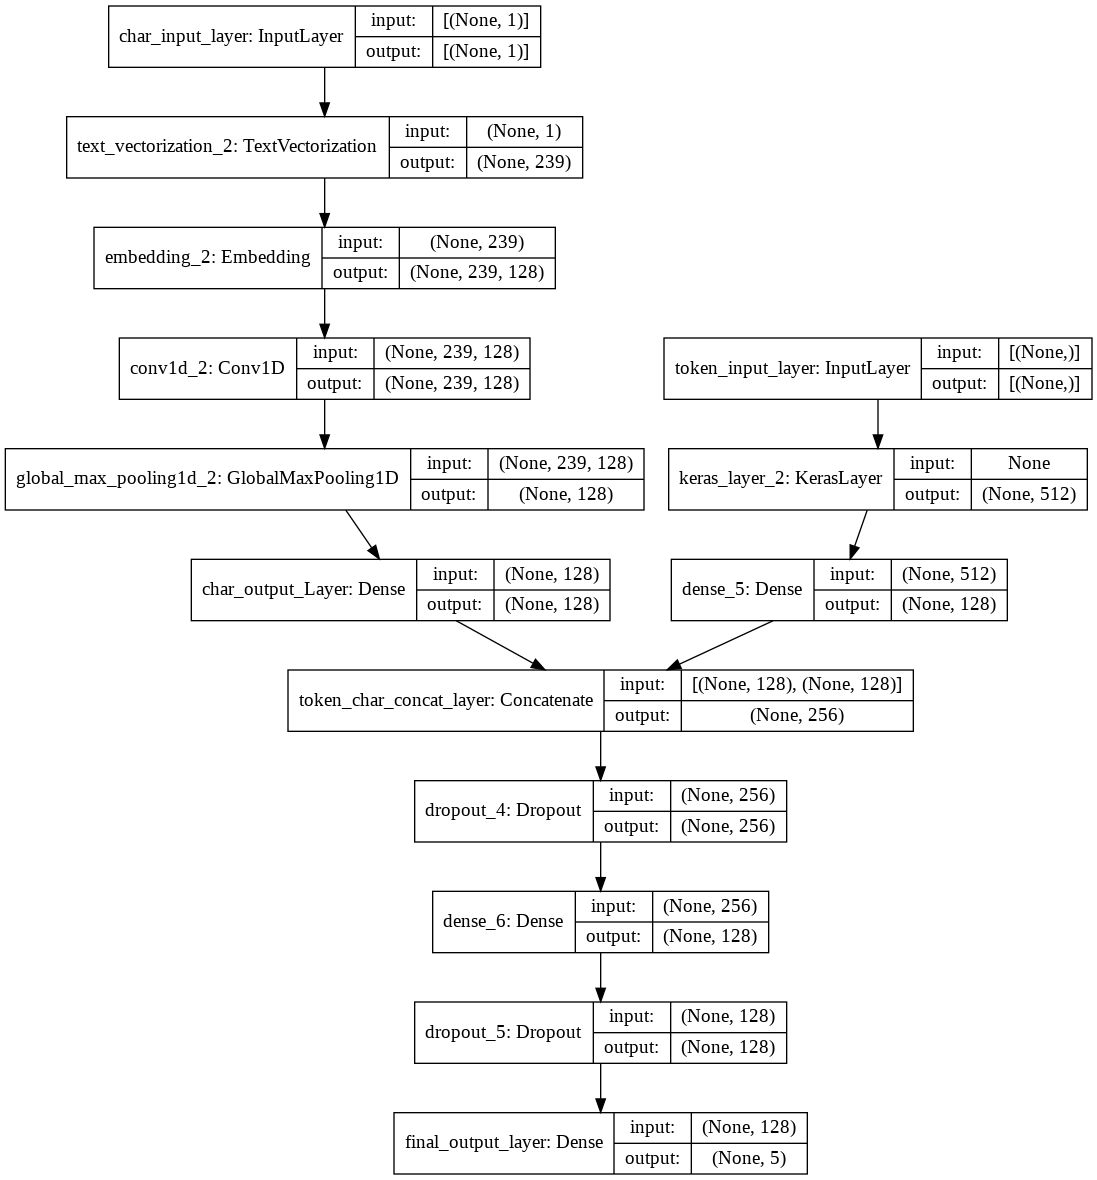

In [55]:
# Compile the model
model_4_20k.compile(loss=SparseCategoricalCrossentropy(),
                   optimizer=Adam(),
                   metrics='accuracy')

In [53]:
train_labels[:10]

array([0, 2, 2, 4, 1, 4, 2, 0, 0, 2], dtype=int64)

In [54]:
# Combining token and character data into tf.data
training_data = tf.data.Dataset.from_tensor_slices((train_texts, train_char)) # Make data
training_labels = tf.data.Dataset.from_tensor_slices((train_labels)) # Make labels
training_dataset = tf.data.Dataset.zip((training_data, training_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

testing_data = tf.data.Dataset.from_tensor_slices((test_texts, test_char))
testing_labels = tf.data.Dataset.from_tensor_slices((test_labels))
testing_dataset = tf.data.Dataset.zip((testing_data, testing_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
training_dataset

<PrefetchDataset shapes: (((None,), (None,)), (None,)), types: ((tf.string, tf.string), tf.int64)>

In [57]:
# Create callbacks
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_4')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_4/model_4.ckpt',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               verbose=1,
                                               monitor='val_accuracy')

# Fit the model
history_4_20k = model_4_20k.fit(training_dataset,
                               epochs=5,
                               steps_per_epoch=int(0.1*len(training_dataset)),
                               validation_data=testing_dataset,
                               validation_steps=int(0.1*len(testing_dataset)),
                               callbacks=[tensorboard, checkpoint])

Epoch 1/5
506/506 [==============================] - ETA: 0s - loss: 0.9915 - accuracy: 0.6015
Epoch 00001: val_accuracy improved from -inf to 0.67243, saving model to PubMed_20k/model_4\model_4.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


506/506 [==============================] - 36s 48ms/step - loss: 0.9915 - accuracy: 0.6015 - val_loss: 0.8314 - val_accuracy: 0.6724
Epoch 2/5
506/506 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.6903
Epoch 00002: val_accuracy improved from 0.67243 to 0.71150, saving model to PubMed_20k/model_4\model_4.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


506/506 [==============================] - 22s 43ms/step - loss: 0.8054 - accuracy: 0.6903 - val_loss: 0.7805 - val_accuracy: 0.7115
Epoch 3/5
505/506 [============================>.] - ETA: 0s - loss: 0.7759 - accuracy: 0.7071
Epoch 00003: val_accuracy improved from 0.71150 to 0.72879, saving model to PubMed_20k/model_4\model_4.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


506/506 [==============================] - 22s 44ms/step - loss: 0.7762 - accuracy: 0.7070 - val_loss: 0.7318 - val_accuracy: 0.7288
Epoch 4/5
504/506 [============================>.] - ETA: 0s - loss: 0.7548 - accuracy: 0.7164
Epoch 00004: val_accuracy improved from 0.72879 to 0.74386, saving model to PubMed_20k/model_4\model_4.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


506/506 [==============================] - 23s 45ms/step - loss: 0.7540 - accuracy: 0.7169 - val_loss: 0.7006 - val_accuracy: 0.7439
Epoch 5/5
504/506 [============================>.] - ETA: 0s - loss: 0.7328 - accuracy: 0.7183
Epoch 00005: val_accuracy improved from 0.74386 to 0.74609, saving model to PubMed_20k/model_4\model_4.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_4\model_4.ckpt\assets


506/506 [==============================] - 24s 48ms/step - loss: 0.7327 - accuracy: 0.7183 - val_loss: 0.6929 - val_accuracy: 0.7461


In [58]:
model_4_20k.evaluate(testing_dataset)

563/563 [==============================] - 13s 23ms/step - loss: 0.6456 - accuracy: 0.7615


[0.6455833911895752, 0.761497437953949]

In [59]:
model_4_20k_pred = np.argmax(model_4_20k.predict(testing_dataset), axis=1)
model_4_20k_pred

array([4, 2, 0, ..., 1, 0, 2], dtype=int64)

In [62]:
model_4_20k_result = calculate_results_model(test_labels, model_4_20k_pred)
model_4_20k_result

{'accuracy': 0.76, 'precision': 0.76, 'recall': 0.76, 'f1_score': 0.76}

In [141]:
def split_char(text):
    return ' '.join(text)

In [142]:
split_char(train_texts[0])

'S o m e   C M   t h e r a p i e s   h a v e   s h o w n   t h e r a p e u t i c   e f f e c t s   f o r   p s o r i a s i s   v u l g a r i s   (   P V   )   ,   i n c l u d i n g   r e l i e v i n g   s y m p t o m s   a n d   i m p r o v i n g   q u a l i t y   o f   l i f e   ,   a n d   m a y   r e d u c e   t h e   r e l a p s e   r a t e   .'

In [ ]:
tokenizer = layers.TextVectorization(max_tokens=68)

In [143]:
train_char = [split_char(text) for text in train_texts]
train_char[0]

'S o m e   C M   t h e r a p i e s   h a v e   s h o w n   t h e r a p e u t i c   e f f e c t s   f o r   p s o r i a s i s   v u l g a r i s   (   P V   )   ,   i n c l u d i n g   r e l i e v i n g   s y m p t o m s   a n d   i m p r o v i n g   q u a l i t y   o f   l i f e   ,   a n d   m a y   r e d u c e   t h e   r e l a p s e   r a t e   .'

In [145]:
train_char[0].split()[:10]

['S', 'o', 'm', 'e', 'C', 'M', 't', 'h', 'e', 'r']

In [147]:
np.mean([len(char.split())for char in train_char])

124.06199239675134

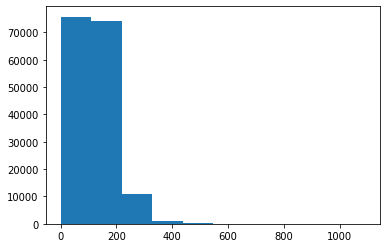

In [149]:
plt.hist([len(char.split())for char in train_char]);

In [176]:
np.percentile([len(char.split())for char in train_char], q=95)

239.0

### Add positional embedding

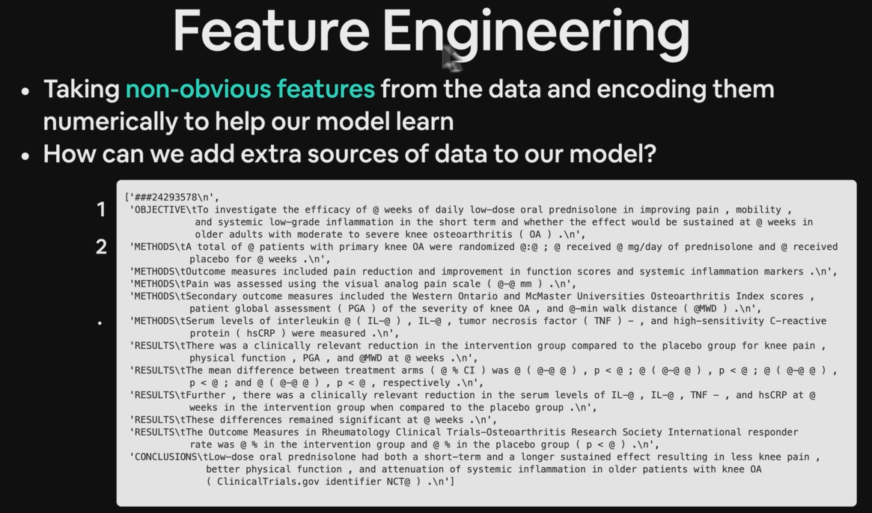

In [30]:
train_df_dummies.head()

text  line_number  total_line  \
0  To investigate the efficacy of @ weeks of dail...            0          11   
1  A total of @ patients with primary knee OA wer...            1          11   
2  Outcome measures included pain reduction and i...            2          11   
3  Pain was assessed using the visual analog pain...            3          11   
4  Secondary outcome measures included the Wester...            4          11   

   target_BACKGROUND  target_CONCLUSIONS  target_METHODS  target_OBJECTIVE  \
0                  0                   0               0                 1   
1                  0                   0               1                 0   
2                  0                   0               1                 0   
3                  0                   0               1                 0   
4                  0                   0               1                 0   

   target_RESULTS  
0               0  
1               0  
2               0  
3               0  
4               0

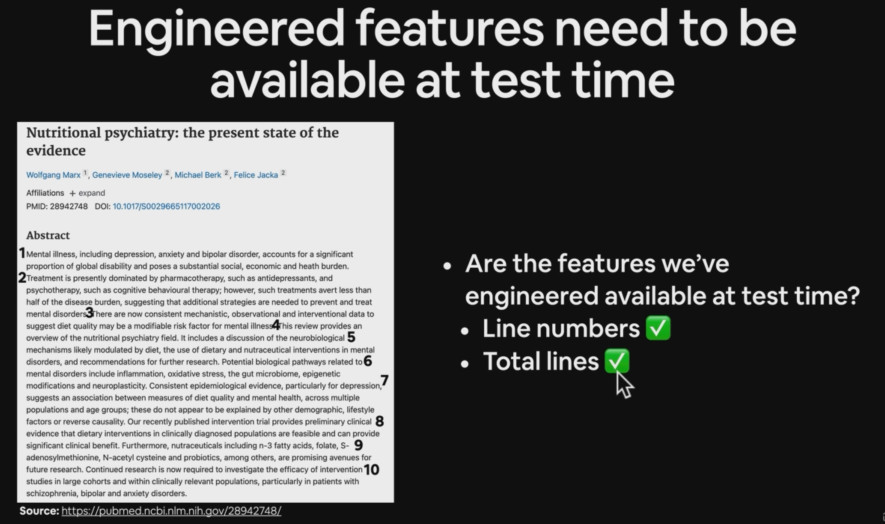

In [31]:
train_df_dummies.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

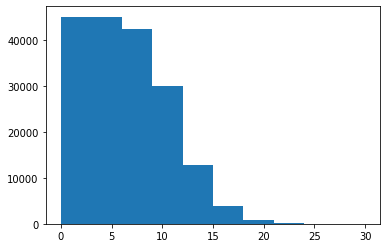

In [32]:
plt.hist(train_df_dummies.line_number);

In [33]:
train_df_dummies.total_line.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_line, dtype: int64

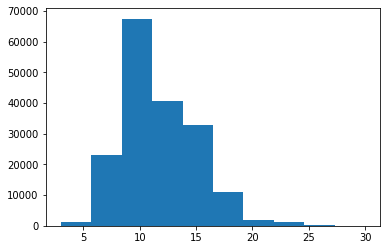

In [34]:
plt.hist(train_df_dummies.total_line);

In [35]:
np.percentile(train_df_dummies.line_number.to_numpy(), q=98)

15.0

In [36]:
np.percentile(train_df_dummies.total_line.to_numpy(), q=98)

20.0

In [37]:
train_line_numbers = tf.one_hot(train_df_dummies.line_number.to_numpy(), depth=15)
train_line_numbers

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [38]:
train_total_lines = tf.one_hot(train_df_dummies.total_line.to_numpy(), depth=20), 
train_total_lines

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,)

In [39]:
train_df_dummies.columns

Index(['text', 'line_number', 'total_line', 'target_BACKGROUND',
       'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE',
       'target_RESULTS'],
      dtype='object')

In [40]:
train_data_full = train_df_dummies.text.to_numpy()
train_label_full = train_df_dummies[[ 'target_BACKGROUND',
       'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE',
       'target_RESULTS']].to_numpy()

In [41]:
train_label_full, train_data_full

(array([[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]], dtype=uint8),
 array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
        'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
        'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
        ...,
        'Both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
        'Compared with standard statin monotherapy , the combination of statin plus ezetimibe showed gr

In [42]:
test_df_dummies = pd.get_dummies(test_df, columns=['target'])
test_df_dummies.head()

text  line_number  total_line  \
0  This study analyzed liver function abnormaliti...            0           8   
1  A post hoc analysis was conducted with the use...            1           8   
2  Liver function tests ( LFTs ) were measured at...            2           8   
3  Survival analyses were used to assess the asso...            3           8   
4  The percentage of patients with abnormal LFTs ...            4           8   

   target_BACKGROUND  target_CONCLUSIONS  target_METHODS  target_OBJECTIVE  \
0                  1                   0               0                 0   
1                  0                   0               0                 0   
2                  0                   0               0                 0   
3                  0                   0               0                 0   
4                  0                   0               0                 0   

   target_RESULTS  
0               0  
1               1  
2               1  
3               1  
4               1

In [43]:
test_data_full = test_df_dummies.text.to_numpy()
test_label_full = test_df_dummies[['target_BACKGROUND',
       'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE',
       'target_RESULTS']].to_numpy()

In [44]:
test_data_full, test_label_full

(array(['This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
        'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
        'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
        ...,
        'There was no significant association between satisfaction and treatment groups at week @ .',
        'No adverse effects were reported .',
        'Performing a @-week do-as-tolerated program of eccentric heel-drop exercises , compared to the recommended @ repetitions per day , did not lead to lesser improvement for individuals with midportion Achilles tendinopathy , based on VISA-A and VAS scores .'],
       dtype=object),
 array([[1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
     

In [45]:
test_total_lines = tf.one_hot(test_df_dummies.total_line.to_numpy(), depth=20)
test_line_numbers = tf.one_hot(test_df_dummies.line_number.to_numpy(), depth=15)

In [46]:
test_line_numbers, test_total_lines

(<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>)

### Tribrid embedding model

1. Create a token-level model
2. Create a char-level model
3. Create a model for 'total_lines' feature
4. Create a model for 'line_number' feature
5. Combine the output of 1 & 2 with 'layers.Concatenate'
6. Combine the output of 3, 4, 5 using 'layers.Concatenate'
7. Create an output layer to accept tribrid embedding and output probabilities
8. Combine the inputs of 1, 2, 3, 4 into tf.keras.Model

In [47]:
# Char Text
train_data_full[:2]

array(['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'],
      dtype=object)

In [48]:
' '.join('To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .')

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [49]:
def split_lines(text):
    return ' '.join(text)

In [50]:
train_data_full_char = [split_lines(sentences) for sentences in train_data_full]
test_data_full_char = [split_lines(sentences) for sentences in test_data_full]

In [51]:
'T o   i n v e s t i g a t e'.split()

['T', 'o', 'i', 'n', 'v', 'e', 's', 't', 'i', 'g', 'a', 't', 'e']

In [52]:
np.mean([len(char.split())for char in train_data_full_char])

124.02798822483892

In [66]:
text_vectorization = layers.TextVectorization(max_tokens=28,
                                             output_sequence_length=125)

In [67]:
train_data_full_char[0]

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [68]:
text_vectorization.adapt(train_data_full_char)

In [69]:
len(text_vectorization.get_vocabulary())

28

In [70]:
text_vectorization('T o   i n v e s t i g a t e')

<tf.Tensor: shape=(125,), dtype=int64, numpy=
array([ 3,  7,  4,  6, 21,  2,  9,  3,  4, 18,  5,  3,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int64)>

In [71]:
embedding_layer = layers.Embedding(input_dim=28,
                                  output_dim=25,
                                  input_length=125,
                                  mask_zero=True)

In [72]:
embedding_layer(text_vectorization('T o   i n v e s t i g a t e'))

<tf.Tensor: shape=(125, 25), dtype=float32, numpy=
array([[-0.03406786,  0.009126  ,  0.02378028, ..., -0.02335402,
        -0.03091583,  0.03416992],
       [ 0.04683472, -0.04823315,  0.00869178, ...,  0.00799643,
        -0.00946385,  0.0012454 ],
       [-0.02178956, -0.03718275, -0.03604269, ...,  0.03411308,
         0.01597878,  0.01340589],
       ...,
       [ 0.01795867, -0.03551086,  0.03395725, ..., -0.01152037,
         0.00545167,  0.02760101],
       [ 0.01795867, -0.03551086,  0.03395725, ..., -0.01152037,
         0.00545167,  0.02760101],
       [ 0.01795867, -0.03551086,  0.03395725, ..., -0.01152037,
         0.00545167,  0.02760101]], dtype=float32)>

In [73]:
train_label_full, train_label_full.shape

(array([[0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        ...,
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]], dtype=uint8),
 (180040, 5))

In [117]:
# Set vectorizer and embedding layer (using USE)
embedding_layer_hub = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                trainable=False)

In [118]:
# Token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embed = embedding_layer_hub(token_inputs)
token_outputs = layers.Dense(128, activation='relu', name='token_outputs')(token_embed)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# Char model
char_inputs = layers.Input(shape=(1), dtype=tf.string, name='char_inputs')
char_vector = text_vectorization(char_inputs)
char_embed = embedding_layer(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
# char_conv1d = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(char_embed)
# char_feat_extract = layers.GlobalMaxPool1D()(char_conv1d)
# char_dense = layers.Dense(128, activation='relu')(char_feat_extract)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Line numbers model
line_number_inputs = layers.Input(shape=(15), dtype=tf.float32, name='line_numbers_model')
line_number_dense = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# Total line model
total_line_inputs = layers.Input(shape=(20), dtype=tf.float32, name='total_line_inputs')
total_line_dense = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs, outputs=total_line_dense)

# Concatenate model
first_concatenate = layers.Concatenate()([token_model.output, char_model.output])

# Dropouts layer
z = layers.Dense(256, activation='relu')(first_concatenate)
z = layers.Dropout(0.5)(z)

# Concatenate model
final_concatenate = layers.Concatenate()([line_number_model.output, 
                                          total_line_model.output, 
                                          z])

# Create final output
final_output = layers.Dense(5, activation='softmax')(final_concatenate)

# Pass the inputs and outputs into model
model_5_20k = tf.keras.Model(inputs=[line_number_model.input,
                                     total_line_model.input,
                                     token_model.input,
                                     char_model.input,],
                             outputs=final_output)

In [119]:
model_5_20k.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 125)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]']    

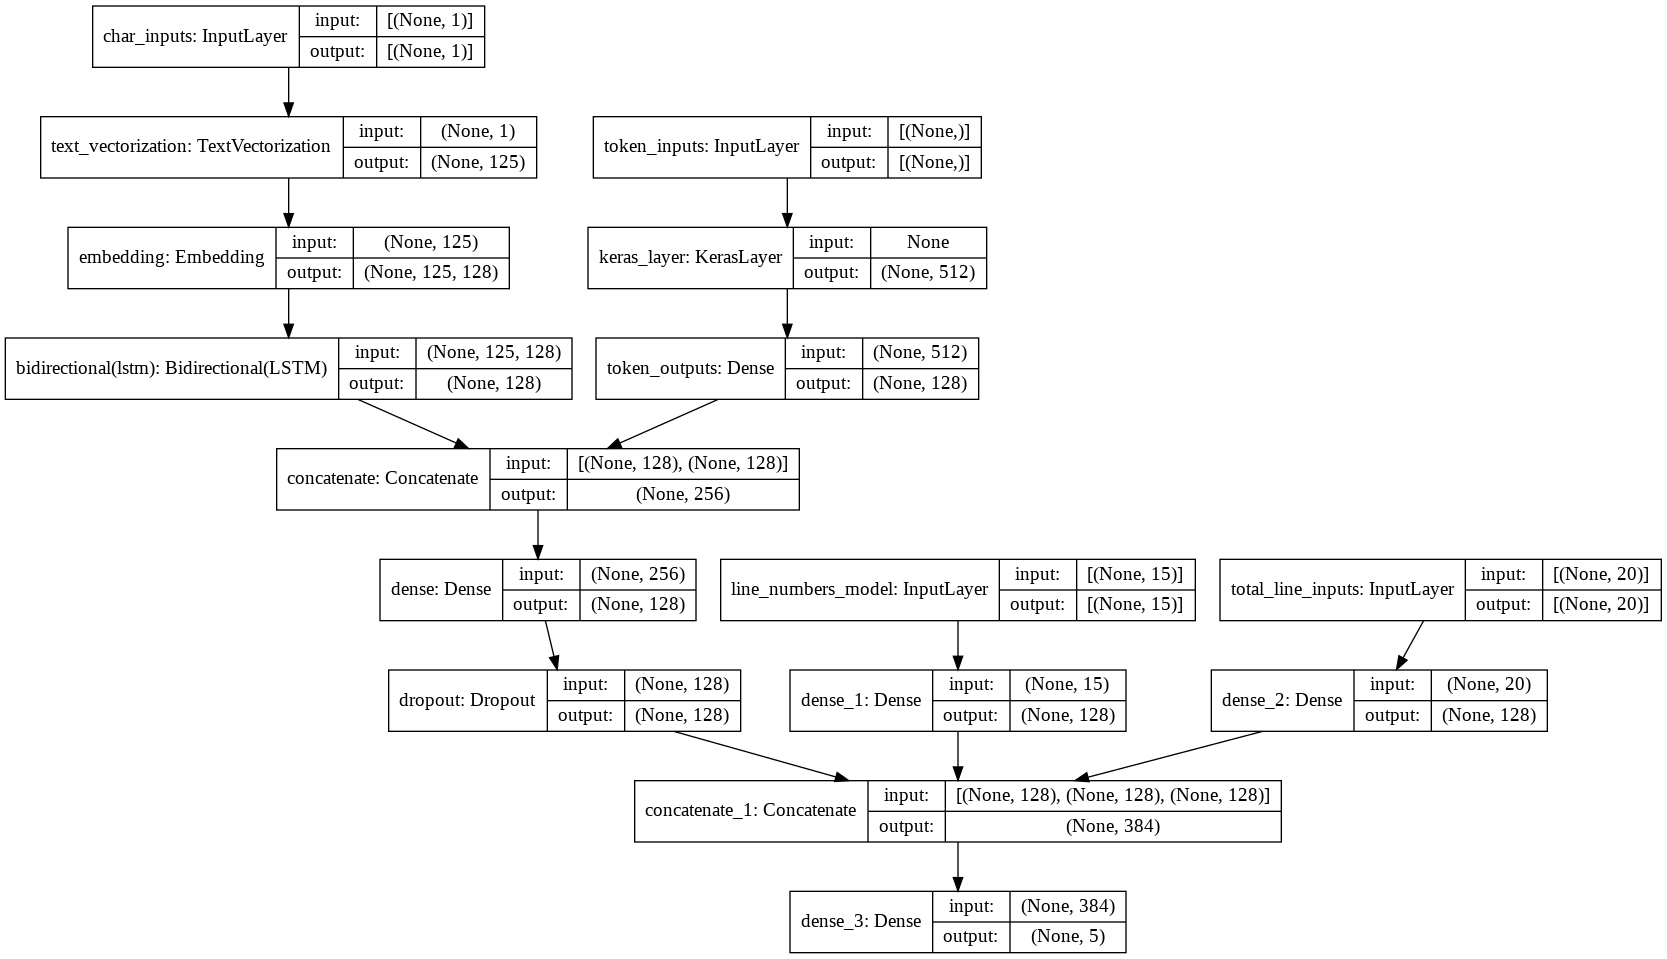

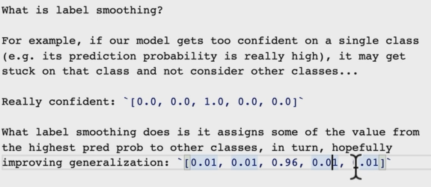

In [120]:
# Compile the model
model_5_20k.compile(optimizer=Adam(),
                   loss=CategoricalCrossentropy(label_smoothing=0.2),
                   metrics='accuracy')

In [121]:
train_label_full_sparse = np.argmax(train_label_full, axis=1)
test_label_full_sparse = np.argmax(test_label_full, axis=1)
test_label_full_sparse[:10]

array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0], dtype=int64)

In [122]:
train_label_full_float = tf.cast(train_label_full, dtype=tf.float64)
test_label_full_float = tf.cast(test_label_full, dtype=tf.float64)
train_label_full_float, test_label_full_float

(<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]])>)

In [123]:
train_data_tribrid = tf.data.Dataset.from_tensor_slices((train_line_numbers,
                                                         train_total_lines,
                                                         train_data_full,
                                                         train_data_full_char))
train_label_tribrid = tf.data.Dataset.from_tensor_slices(train_label_full_float)
train_dataset_full_tribrid = tf.data.Dataset.zip((train_data_tribrid, train_label_tribrid)).batch(32).prefetch(tf.data.AUTOTUNE)

test_data_tribrid = tf.data.Dataset.from_tensor_slices((test_line_numbers, test_total_lines, test_data_full, test_data_full_char))
test_label_tribrid = tf.data.Dataset.from_tensor_slices((test_label_full_float))
test_dataset_full_tribrid = tf.data.Dataset.zip((test_data_tribrid, test_label_tribrid)).batch(32).prefetch(tf.data.AUTOTUNE)

In [124]:
train_dataset_full_tribrid

<PrefetchDataset shapes: (((None, 15), ((None, 20),), (None,), (None,)), (None, 5)), types: ((tf.float32, (tf.float32,), tf.string, tf.string), tf.float64)>

In [125]:
test_dataset_full_tribrid

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [126]:
# Create callbacks 
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_5/model_5.ckpt',
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False)



# Fit the model
history_5 = model_5_20k.fit(train_dataset_full_tribrid,
                           steps_per_epoch=int(0.1 * len(train_dataset_full_tribrid)),
                           epochs=5,
                           validation_data=test_dataset_full_tribrid,
                           validation_steps=int(0.1 * len(test_dataset_full_tribrid)),
                           callbacks=[tensorboard, checkpoint])

Epoch 1/5
562/562 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.7152 ETA: 2s - loss: 1.1126 - accuracy: 0.71 - ETA: 2s - loss: 1.1124 -  - ETA: 2s - loss: 1.1107 - ac
Epoch 00001: val_accuracy improved from -inf to 0.78624, saving model to PubMed_20k/model_5\model_5.ckpt


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


562/562 [==============================] - 82s 127ms/step - loss: 1.1054 - accuracy: 0.7152 - val_loss: 1.0068 - val_accuracy: 0.7862
Epoch 2/5
562/562 [==============================] - ETA: 0s - loss: 0.9694 - accuracy: 0.8137
Epoch 00002: val_accuracy improved from 0.78624 to 0.81017, saving model to PubMed_20k/model_5\model_5.ckpt


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


562/562 [==============================] - 72s 128ms/step - loss: 0.9694 - accuracy: 0.8137 - val_loss: 0.9708 - val_accuracy: 0.8102
Epoch 3/5
562/562 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.8213
Epoch 00003: val_accuracy improved from 0.81017 to 0.82812, saving model to PubMed_20k/model_5\model_5.ckpt


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


562/562 [==============================] - 66s 117ms/step - loss: 0.9525 - accuracy: 0.8213 - val_loss: 0.9507 - val_accuracy: 0.8281
Epoch 4/5
562/562 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.8343
Epoch 00004: val_accuracy improved from 0.82812 to 0.82912, saving model to PubMed_20k/model_5\model_5.ckpt


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


562/562 [==============================] - 69s 122ms/step - loss: 0.9414 - accuracy: 0.8343 - val_loss: 0.9383 - val_accuracy: 0.8291
Epoch 5/5
561/562 [============================>.] - ETA: 0s - loss: 0.9382 - accuracy: 0.8348
Epoch 00005: val_accuracy improved from 0.82912 to 0.83112, saving model to PubMed_20k/model_5\model_5.ckpt


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


562/562 [==============================] - 71s 127ms/step - loss: 0.9381 - accuracy: 0.8349 - val_loss: 0.9352 - val_accuracy: 0.8311


In [127]:
model_5_20k.save('skimlit_model_5')

INFO:tensorflow:Assets written to: skimlit_model_5\assets


INFO:tensorflow:Assets written to: skimlit_model_5\assets


In [2]:
loaded_model = load_model('skimlit_model_5/')

ValueError: Exception encountered when calling layer "forward_lstm" (type LSTM).

The mask that was passed in was tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64)), which cannot be applied to RaggedTensor inputs. Please make sure that there is no mask injected by upstream layers.

Call arguments received:
  • inputs=tf.RaggedTensor(values=Tensor("Placeholder:0", shape=(None, 25), dtype=float32), row_splits=Tensor("Placeholder_1:0", shape=(None,), dtype=int64))
  • mask=tf.RaggedTensor(values=Tensor("Placeholder_2:0", shape=(None,), dtype=bool), row_splits=Tensor("Placeholder_3:0", shape=(None,), dtype=int64))
  • training=None
  • initial_state=None

In [219]:
model_5_20k.evaluate(test_dataset_full_tribrid)

942/942 [==============================] - 14s 15ms/step - loss: 0.9199 - accuracy: 0.8454


[0.9199413657188416, 0.8454288840293884]

In [223]:
model_5_20k_pred = np.argmax(model_5_20k.predict(test_dataset_full_tribrid), axis=1)
calculate_results_model(test_label_full_sparse, model_5_20k_pred)

{'accuracy': 0.85, 'precision': 0.84, 'recall': 0.85, 'f1_score': 0.84}

## Fit with 100% of train data

In [232]:
# Create callbacks 
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_5/model_5.ckpt',
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False)



# Fit the model
history_5_full = model_5_20k.fit(train_dataset_full_tribrid,
                           epochs=5,
                           validation_data=test_dataset_full_tribrid,
                           validation_steps=int(0.1 * len(test_dataset_full_tribrid)),
                           callbacks=[tensorboard, checkpoint])

Epoch 1/5
5627/5627 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.8256
Epoch 00001: val_accuracy improved from -inf to 0.84874, saving model to PubMed_20k/model_5\model_5.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


5627/5627 [==============================] - 117s 20ms/step - loss: 0.9500 - accuracy: 0.8256 - val_loss: 0.9119 - val_accuracy: 0.8487
Epoch 2/5
5627/5627 [==============================] - ETA: 0s - loss: 0.9026 - accuracy: 0.8579
Epoch 00002: val_accuracy did not improve from 0.84874
5627/5627 [==============================] - 102s 18ms/step - loss: 0.9026 - accuracy: 0.8579 - val_loss: 0.9069 - val_accuracy: 0.8477
Epoch 3/5
5625/5627 [============================>.] - ETA: 0s - loss: 0.8892 - accuracy: 0.8677
Epoch 00003: val_accuracy improved from 0.84874 to 0.85040, saving model to PubMed_20k/model_5\model_5.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_20k/model_5\model_5.ckpt\assets


5627/5627 [==============================] - 106s 19ms/step - loss: 0.8892 - accuracy: 0.8677 - val_loss: 0.9020 - val_accuracy: 0.8504
Epoch 4/5
5627/5627 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.8744
Epoch 00004: val_accuracy did not improve from 0.85040
5627/5627 [==============================] - 93s 17ms/step - loss: 0.8804 - accuracy: 0.8744 - val_loss: 0.9039 - val_accuracy: 0.8504
Epoch 5/5
5625/5627 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.8795
Epoch 00005: val_accuracy did not improve from 0.85040
5627/5627 [==============================] - 94s 17ms/step - loss: 0.8734 - accuracy: 0.8795 - val_loss: 0.9044 - val_accuracy: 0.8504


In [234]:
model_5_20k.evaluate(test_dataset_full_tribrid)

942/942 [==============================] - 30s 31ms/step - loss: 0.8995 - accuracy: 0.85260s -


[0.8994554281234741, 0.8526298403739929]

## Model 6

In [101]:
train_data_full[0]

'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'

In [102]:
'To investigate the efficacy'.split()

['To', 'investigate', 'the', 'efficacy']

In [103]:
np.mean([len(text.split()) for text in train_data_full])

26.338269273494777

In [104]:
np.percentile([len(text.split()) for text in train_data_full], q=95)

55.0

In [105]:
token_vectorization = layers.TextVectorization(max_tokens=68000,
                                              output_sequence_length=55)

In [106]:
token_vectorization.adapt(train_data_full)

In [107]:
token_embedding = layers.Embedding(input_dim=68000,
                                  output_dim=128,
                                  input_length=55,
                                  mask_zero=True)

In [108]:
tf.random.set_seed(42)

# Token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_vector = token_vectorization(token_inputs)
token_embed = token_embedding(token_vector)
token_conv1d = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(token_embed)
token_feat_extract = layers.GlobalMaxPool1D()(token_conv1d)
token_outputs = layers.Dense(128, activation='relu', name='token_outputs')(token_feat_extract)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# Char model
char_inputs = layers.Input(shape=(1), dtype=tf.string, name='char_inputs')
char_vector = text_vectorization(char_inputs)
char_embed = embedding_layer(char_vector)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_conv1d = layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(char_embed)
char_feat_extract = layers.GlobalMaxPool1D()(char_conv1d)
char_dense = layers.Dense(128, activation='relu')(char_feat_extract)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_dense)

# Line numbers model
line_number_inputs = layers.Input(shape=(15), dtype=tf.float32, name='line_numbers_model')
line_number_dense = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# Total line model
total_line_inputs = layers.Input(shape=(20), dtype=tf.float32, name='total_line_inputs')
total_line_dense = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs, outputs=total_line_dense)

# Concatenate model
first_concatenate = layers.Concatenate()([token_model.output, char_model.output])

# Dropouts layer
z = layers.Dense(256, activation='relu')(first_concatenate)
z = layers.Dropout(0.5)(z)

# Concatenate model
final_concatenate = layers.Concatenate()([line_number_model.output, 
                                          total_line_model.output, 
                                          z])

# Create final output
final_output = layers.Dense(5, activation='softmax')(final_concatenate)

# Pass the inputs and outputs into model
model_6_20k = tf.keras.Model(inputs=[line_number_model.input,
                                     total_line_model.input,
                                     token_model.input,
                                     char_model.input,],
                             outputs=final_output)

In [109]:
# Compile the model
model_6_20k.compile(optimizer=Adam(),
                   loss=CategoricalCrossentropy(label_smoothing=0.2),
                   metrics='accuracy')

In [110]:
# Create callbacks 
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_6')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_6/model_6.ckpt',
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False)



# Fit the model
history_6 = model_6_20k.fit(train_dataset_full_tribrid,
                           steps_per_epoch=int(0.1 * len(train_dataset_full_tribrid)),
                           epochs=5,
                           validation_data=test_dataset_full_tribrid,
                           validation_steps=int(0.1 * len(test_dataset_full_tribrid)),
                           callbacks=[tensorboard, checkpoint])

Epoch 1/5
561/562 [============================>.] - ETA: 0s - loss: 1.0825 - accuracy: 0.7272
Epoch 00001: val_accuracy improved from -inf to 0.83577, saving model to PubMed_20k/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_6\model_6.ckpt\assets
562/562 [==============================] - 15s 25ms/step - loss: 1.0821 - accuracy: 0.7275 - val_loss: 0.9275 - val_accuracy: 0.8358
Epoch 2/5
560/562 [============================>.] - ETA: 0s - loss: 0.9286 - accuracy: 0.8448
Epoch 00002: val_accuracy improved from 0.83577 to 0.84475, saving model to PubMed_20k/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_6\model_6.ckpt\assets
562/562 [==============================] - 14s 25ms/step - loss: 0.9286 - accuracy: 0.8448 - val_loss: 0.9185 - val_accuracy: 0.8447
Epoch 3/5
561/562 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.8498
Epoch 00003: val_accuracy improved from 0.84475 to 0.85505, saving model to PubMed_20k/m

In [111]:
model_6_20k.evaluate(test_dataset_full_tribrid)

942/942 [==============================] - 7s 8ms/step - loss: 0.8873 - accuracy: 0.8635


[0.8873254656791687, 0.8635141849517822]

In [112]:
model_6_20k_pred = np.argmax(model_6_20k.predict(test_dataset_full_tribrid), axis=1)

In [113]:
calculate_results_model(test_label_full_sparse, model_6_20k_pred)

{'accuracy': 0.86, 'precision': 0.87, 'recall': 0.86, 'f1_score': 0.86}

In [114]:
model_6_20k.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model\assets


In [115]:
loaded_model = load_model('skimlit_tribrid_model/')

TypeError: Exception encountered when calling layer "conv1d_15" (type Conv1D).

Failed to convert elements of tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("Placeholder:0", shape=(None, 128), dtype=float32), row_splits=Tensor("Placeholder_1:0", shape=(None,), dtype=int64)), row_splits=Tensor("conv1d_15/Conv1D/RaggedExpandDims/RaggedFromUniformRowLength/RowPartitionFromUniformRowLength/mul:0", shape=(None,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.

Call arguments received:
  • inputs=tf.RaggedTensor(values=Tensor("Placeholder:0", shape=(None, 128), dtype=float32), row_splits=Tensor("Placeholder_1:0", shape=(None,), dtype=int64))

In [91]:
# Create callbacks 
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_20k/model_6')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='PubMed_20k/model_6/model_6.ckpt',
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_best_only=True,
                                               save_weights_only=False)



# Fit the model
history_6 = model_6_20k.fit(train_dataset_full_tribrid,
                           epochs=5,
                           validation_data=test_dataset_full_tribrid,
                           validation_steps=int(0.1 * len(test_dataset_full_tribrid)),
                           callbacks=[tensorboard, checkpoint])

Epoch 1/5
5627/5627 [==============================] - ETA: 0s - loss: 0.8446 - accuracy: 0.8998
Epoch 00001: val_accuracy improved from -inf to 0.85206, saving model to PubMed_20k/model_6\model_6.ckpt
INFO:tensorflow:Assets written to: PubMed_20k/model_6\model_6.ckpt\assets
5627/5627 [==============================] - 109s 19ms/step - loss: 0.8446 - accuracy: 0.8998 - val_loss: 0.8904 - val_accuracy: 0.8521
Epoch 2/5
5627/5627 [==============================] - ETA: 0s - loss: 0.7954 - accuracy: 0.9309 ETA: 0s - loss: 0.795
Epoch 00002: val_accuracy did not improve from 0.85206
5627/5627 [==============================] - 105s 19ms/step - loss: 0.7954 - accuracy: 0.9309 - val_loss: 0.9251 - val_accuracy: 0.8351
Epoch 3/5
5625/5627 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.9528
Epoch 00003: val_accuracy did not improve from 0.85206
5627/5627 [==============================] - 105s 19ms/step - loss: 0.7636 - accuracy: 0.9528 - val_loss: 0.9361 - val_accurac

### USE Model

In [235]:
train_texts.shape, train_labels.shape

((162036,), (162036,))

In [7]:
embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                input_shape=[],
                                dtype=tf.string,
                                trainable=False)

In [236]:
# Create a model
model_1 = Sequential([
    embedding_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile a model
model_1.compile(optimizer=Adam(),
               loss=SparseCategoricalCrossentropy(),
               metrics='accuracy')

# Create a callback
tensorboard = tf.keras.callbacks.TensorBoard('PubMed/model_1')
checkpoint = tf.keras.callbacks.ModelCheckpoint('PubMed/model_1/model_1.ckpt',
                                               monitor='val_accuracy',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               verbose=1)

In [237]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [238]:
# Fit a model
model_1.fit(train_texts,
           train_labels,
           epochs=10,
           validation_data=(test_texts, test_labels),
           callbacks=[tensorboard, checkpoint])

Epoch 1/10
5061/5064 [============================>.] - ETA: 0s - loss: 0.7320 - accuracy: 0.7188
Epoch 00001: val_accuracy improved from -inf to 0.74917, saving model to PubMed/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


5064/5064 [==============================] - 83s 16ms/step - loss: 0.7319 - accuracy: 0.7189 - val_loss: 0.6599 - val_accuracy: 0.7492
Epoch 2/10
5064/5064 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7581
Epoch 00002: val_accuracy improved from 0.74917 to 0.76466, saving model to PubMed/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


5064/5064 [==============================] - 72s 14ms/step - loss: 0.6357 - accuracy: 0.7581 - val_loss: 0.6230 - val_accuracy: 0.7647
Epoch 3/10
5064/5064 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7720
Epoch 00003: val_accuracy improved from 0.76466 to 0.76950, saving model to PubMed/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


5064/5064 [==============================] - 71s 14ms/step - loss: 0.6005 - accuracy: 0.7720 - val_loss: 0.6052 - val_accuracy: 0.7695
Epoch 4/10
5063/5064 [============================>.] - ETA: 0s - loss: 0.5767 - accuracy: 0.7826 ETA: 
Epoch 00004: val_accuracy improved from 0.76950 to 0.77561, saving model to PubMed/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed/model_1\model_1.ckpt\assets


5064/5064 [==============================] - 75s 15ms/step - loss: 0.5766 - accuracy: 0.7826 - val_loss: 0.5980 - val_accuracy: 0.7756
Epoch 5/10
5063/5064 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.7897
Epoch 00005: val_accuracy did not improve from 0.77561
5064/5064 [==============================] - 67s 13ms/step - loss: 0.5589 - accuracy: 0.7897 - val_loss: 0.5998 - val_accuracy: 0.7747
Epoch 6/10
5060/5064 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.7957
Epoch 00006: val_accuracy did not improve from 0.77561
5064/5064 [==============================] - 66s 13ms/step - loss: 0.5441 - accuracy: 0.7956 - val_loss: 0.5983 - val_accuracy: 0.7719
Epoch 7/10
5061/5064 [============================>.] - ETA: 0s - loss: 0.5311 - accuracy: 0.7997
Epoch 00007: val_accuracy did not improve from 0.77561
5064/5064 [==============================] - 66s 13ms/step - loss: 0.5311 - accuracy: 0.7997 - val_loss: 0.6025 - val_accuracy: 0.7737
E

In [239]:
model_1_best = load_model('PubMed/model_1/model_1.ckpt/')

In [246]:
for layer in model_1_best.layers:
    print(layer.name, layer.trainable)

keras_layer False
dense_2 True
dense_3 True


In [247]:
model_1_best.evaluate(test_texts, test_labels)

563/563 [==============================] - 10s 16ms/step - loss: 0.5980 - accuracy: 0.7756


[0.5979716777801514, 0.7756054401397705]

In [250]:
model_1_pred = model_1_best.predict(test_texts)
model_1_pred = np.argmax(model_1_pred, axis=1)

In [251]:
model_1_pred[:5]

array([2, 1, 0, 2, 1], dtype=int64)

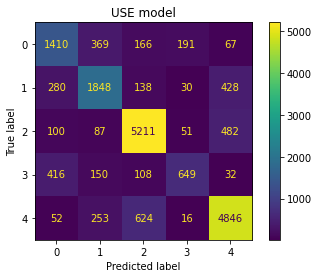

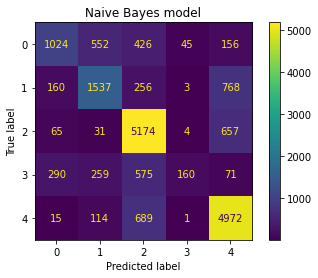

In [270]:
ConfusionMatrixDisplay.from_predictions(test_labels, model_1_pred);
plt.title('USE model')
ConfusionMatrixDisplay.from_predictions(test_labels, baseline_pred);
plt.title('Naive Bayes model');

In [272]:
print(classification_report(test_labels, model_1_pred))
print(classification_report(test_labels, baseline_pred))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63      2203
           1       0.68      0.68      0.68      2724
           2       0.83      0.88      0.86      5931
           3       0.69      0.48      0.57      1355
           4       0.83      0.84      0.83      5791

    accuracy                           0.78     18004
   macro avg       0.73      0.70      0.71     18004
weighted avg       0.77      0.78      0.77     18004

              precision    recall  f1-score   support

           0       0.66      0.46      0.55      2203
           1       0.62      0.56      0.59      2724
           2       0.73      0.87      0.79      5931
           3       0.75      0.12      0.20      1355
           4       0.75      0.86      0.80      5791

    accuracy                           0.71     18004
   macro avg       0.70      0.58      0.59     18004
weighted avg       0.71      0.71      0.69     18004



### With 200k of data

In [3]:
def text_readlines(directory):
    with open(directory, mode='r') as f:
        return f.readlines()

def text_preprocess(directory):
    list_text = text_readlines(directory)
    
    sentences = ''
    list_of_dict = []
    
    for text in list_text:
        if text.startswith('###'): # change the number id into ''
            sentences = ''
            
        elif text.isspace(): # if there is a space ('\t', '\n')
            text_split = sentences.splitlines()
            for i, text in enumerate(text_split):
                text_dict = {}
                target = text.split('\t')[0]
                text = text.split('\t')[1]
                text_dict['target'] = target
                text_dict['text'] = text
                text_dict['line_number'] = i
                text_dict['total_line'] = len(text_split)-1
                list_of_dict.append(text_dict)
        else:
            sentences += text

    return list_of_dict
        

In [4]:
train_200k = text_preprocess('skimlit_train/train.txt')

In [5]:
train_200k[:10]

[{'target': 'BACKGROUND',
  'text': 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_line': 10},
 {'target': 'BACKGROUND',
  'text': 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
  'line_number': 1,
  'total_line': 10},
 {'target': 'METHODS',
  'text': 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_line': 10},
 {'target': 'METHODS',
  'text': "The intervention group will participate in the online group program ` Positive Outlook ' .",
  'line_number': 3,
  'total_line': 10},
 {'target': 'METHODS',
  'text

In [6]:
len(train_200k)

2211861

In [7]:
train_200k_df = pd.DataFrame(train_200k)

In [8]:
train_200k_df.head()

target                                               text  line_number  \
0  BACKGROUND  The emergence of HIV as a chronic condition me...            0   
1  BACKGROUND  This paper describes the design and evaluation...            1   
2     METHODS  This study is designed as a randomised control...            2   
3     METHODS  The intervention group will participate in the...            3   
4     METHODS  The program is based on self-efficacy theory a...            4   

   total_line  
0          10  
1          10  
2          10  
3          10  
4          10

In [9]:
train_200k_df = pd.get_dummies(train_200k_df, columns=['target'])
train_200k_df.head()

text  line_number  total_line  \
0  The emergence of HIV as a chronic condition me...            0          10   
1  This paper describes the design and evaluation...            1          10   
2  This study is designed as a randomised control...            2          10   
3  The intervention group will participate in the...            3          10   
4  The program is based on self-efficacy theory a...            4          10   

   target_BACKGROUND  target_CONCLUSIONS  target_METHODS  target_OBJECTIVE  \
0                  1                   0               0                 0   
1                  1                   0               0                 0   
2                  0                   0               1                 0   
3                  0                   0               1                 0   
4                  0                   0               1                 0   

   target_RESULTS  
0               0  
1               0  
2               0  
3               0  
4               0

In [10]:
train_200k_df.columns

Index(['text', 'line_number', 'total_line', 'target_BACKGROUND',
       'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE',
       'target_RESULTS'],
      dtype='object')

### Baseline

In [11]:
text = train_200k_df.text.to_numpy()
label = np.argmax(train_200k_df[['target_BACKGROUND', 'target_CONCLUSIONS', 'target_METHODS', 'target_OBJECTIVE', 'target_RESULTS']].to_numpy(), axis=1)

In [12]:
text[:5]

array(['The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
       'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
       'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
       "The intervention group will participate in the online group program ` Positive Outlook ' .",
       'The program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .'],
      dtype=object)

In [13]:
label[:5]

array([0, 0, 2, 2, 2], dtype=int64)

In [14]:
text.shape, label.shape

((2211861,), (2211861,))

In [15]:
train_text_200k, test_text_200k, train_label_200k, test_label_200k = train_test_split(text,
                                                                                     label,
                                                                                     test_size=0.1,
                                                                                     random_state=42)

In [16]:
len(train_200k_df), len(test_text_200k)

(2211861, 221187)

In [297]:
%%time
# Set random seed
np.random.seed(42)

# Create a model
baseline_200k = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('naive_bayes', MultinomialNB())
])

# Fit a model
baseline_200k.fit(train_text_200k, train_label_200k)

Wall time: 38.8 s


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('naive_bayes', MultinomialNB())])

In [298]:
baseline_200k.score(test_text_200k, test_label_200k)

0.759181145365686

### USE Model

In [318]:
# Set half precision training
tf.keras.mixed_precision.set_global_policy('float32')

# Create a model
model_1_200k = Sequential([
    embedding_layer,
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile a model
model_1_200k.compile(optimizer=Adam(),
               loss=SparseCategoricalCrossentropy(),
               metrics='accuracy')

# Create a callback
tensorboard = tf.keras.callbacks.TensorBoard('PubMed_200k/model_1')
checkpoint = tf.keras.callbacks.ModelCheckpoint('PubMed_200k/model_1/model_1.ckpt',
                                               monitor='val_accuracy',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               verbose=1)

In [319]:
model_1_200k.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 257,063,045
Trainable params: 265,221
Non-trainable params: 256,797,824
_________________________________________________________________


In [320]:
for layer in model_1_200k.layers:
    print(layer.name, layer.dtype_policy)

keras_layer <Policy "string">
dense_16 <Policy "float32">
dense_17 <Policy "float32">


In [322]:
# Fit a model
history_model_1 = model_1_200k.fit(train_text_200k,
                                   train_label_200k,
                                   epochs=10,
                                   batch_size=32,
                                   validation_data=(test_text_200k, test_label_200k),
                                   callbacks=[tensorboard, checkpoint])

Epoch 1/10
62207/62209 [============================>.] - ETA: 0s - loss: 0.5576 - accuracy: 0.7921
Epoch 00001: val_accuracy improved from -inf to 0.80278, saving model to PubMed_200k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


62209/62209 [==============================] - 1107s 18ms/step - loss: 0.5576 - accuracy: 0.7921 - val_loss: 0.5315 - val_accuracy: 0.8028
Epoch 2/10
62208/62209 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.8090
Epoch 00002: val_accuracy improved from 0.80278 to 0.80842, saving model to PubMed_200k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


62209/62209 [==============================] - 1107s 18ms/step - loss: 0.5149 - accuracy: 0.8090 - val_loss: 0.5173 - val_accuracy: 0.8084
Epoch 3/10
62209/62209 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8148
Epoch 00003: val_accuracy improved from 0.80842 to 0.80984, saving model to PubMed_200k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


62209/62209 [==============================] - 1108s 18ms/step - loss: 0.4990 - accuracy: 0.8148 - val_loss: 0.5133 - val_accuracy: 0.8098
Epoch 4/10
62207/62209 [============================>.] - ETA: 0s - loss: 0.4886 - accuracy: 0.8185
Epoch 00004: val_accuracy improved from 0.80984 to 0.81001, saving model to PubMed_200k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


62209/62209 [==============================] - 1105s 18ms/step - loss: 0.4886 - accuracy: 0.8185 - val_loss: 0.5121 - val_accuracy: 0.8100
Epoch 5/10
62208/62209 [============================>.] - ETA: 0s - loss: 0.4806 - accuracy: 0.8215
Epoch 00005: val_accuracy improved from 0.81001 to 0.81082, saving model to PubMed_200k/model_1\model_1.ckpt
INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


INFO:tensorflow:Assets written to: PubMed_200k/model_1\model_1.ckpt\assets


62209/62209 [==============================] - 1267s 20ms/step - loss: 0.4806 - accuracy: 0.8215 - val_loss: 0.5117 - val_accuracy: 0.8108
Epoch 6/10
62207/62209 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.8239
Epoch 00006: val_accuracy did not improve from 0.81082
62209/62209 [==============================] - 1236s 20ms/step - loss: 0.4746 - accuracy: 0.8239 - val_loss: 0.5127 - val_accuracy: 0.8095
Epoch 7/10
62208/62209 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8253
Epoch 00007: val_accuracy did not improve from 0.81082
62209/62209 [==============================] - 1111s 18ms/step - loss: 0.4694 - accuracy: 0.8253 - val_loss: 0.5117 - val_accuracy: 0.8105
Epoch 8/10
62208/62209 [============================>.] - ETA: 0s - loss: 0.4649 - accuracy: 0.8271
Epoch 00008: val_accuracy did not improve from 0.81082
62209/62209 [==============================] - 1137s 18ms/step - loss: 0.4649 - accuracy: 0.8271 - val_loss: 0.5158 - 

In [323]:
### Get classnames

classnames = {0:'BACKGROUND',
             1:'CONCLUSIONS',
             2:'METHODS',
             3:'OBJECTIVE',
             4:'RESULTS'}

In [18]:
model_1_200k_best = load_model('PubMed_200k/model_1/model_1.ckpt/')

In [19]:
model_1_200k_best.evaluate(test_text_200k, test_label_200k)

6913/6913 [==============================] - 135s 19ms/step - loss: 0.5117 - accuracy: 0.8108


[0.5117009282112122, 0.8108206987380981]

In [20]:
model_1_200k_pred = np.round(model_1_200k_best.predict(test_text_200k))

In [21]:
from helper_functions import calculate_results